# Setup the optimization problem

## Ensure path (weight vector -> loss on MNIST) is differentiable

# Train two networks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


import lovely_tensors as lt
lt.monkey_patch()

from tqdm.auto import tqdm

In [2]:
device = 'cuda:0'
batch_size = 128
seed = 0

In [3]:
try:
    from prettytable import PrettyTable
except:
    ! pip install -q prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params} type {type(model)}")
    return total_params

In [4]:
# ! pip install random-fourier-features-pytorch
import rff

In [5]:
sigma=10.0
input_size=2
encoded_size=64

b = rff.functional.sample_b(sigma, (encoded_size, input_size)).to(device)


def encode(v):
    vp = 2 * np.pi * v @ b.T
    return torch.cat((torch.cos(vp), torch.sin(vp)), dim=-1)

In [6]:
def to01(t):
    t = t - t.min()
    t = t / t.max()
    return t

def tensor2pil(t):
    return Image.fromarray((t.detach().cpu().clip(0, 1).numpy()*255).astype(np.uint8))

def pil2tensor(pil): return torch.tensor(
    np.asarray(pil).astype(np.float32)/255).permute(2, 0, 1)


def imagify_tensor(t): 
    return to01(t).cpu().view(256,256).detach()

In [7]:
def init_splitact_Wb_randn(insize, outsize, device):
    W = torch.randn(insize, outsize*4, device=device)
    b = torch.randn(outsize*4, device=device)
    return W, b

def init_splitact_Wb_pytorch(insize, outsize, device):
    ksqrt = (1/insize)**0.5
    W = (torch.rand(insize, outsize*4, device=device) - 0.5) * 2 * ksqrt
    b = (torch.rand(outsize*4, device=device) - 0.5) * 2 * ksqrt

    return W, b

def init_splitact_Wb(insize, outsize, device):
    return init_splitact_Wb_pytorch(insize, outsize, device)

In [8]:
def splitlayer_forward(input_h, W, b):
    hpreact = input_h@W + b
    hpreact_tanh, hpreact_sigmoid, hpreact_sin, hpreact_cos = hpreact.chunk(4, dim=-1)
    htanh, hsigmoid, hsin, hcos = hpreact_tanh.tanh(), hpreact_sigmoid.sigmoid(), hpreact_sin.sin(), hpreact_cos.cos()
    h = htanh*hsigmoid*hsin*hcos

    return h, {'internal_activations': [hpreact, hpreact_tanh, hpreact_sigmoid, hpreact_sin, hpreact_cos, htanh, hsigmoid, hsin, hcos]}

In [9]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [10]:
seed_all(0)

In [11]:
def mse_and_psnr(im_a, im_b, data_range=1): 
    data_range = 1.
    mse = F.mse_loss(im_a, im_b)
    psnr = 10 * torch.log10((data_range ** 2) / mse)
    return mse, psnr

In [12]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [13]:
def get_cameraman_tensor(sidelength):
    pil_img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(pil_img)
    return img, pil_img

class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img, pil_img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        self.pil_img = pil_img

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
        return self.coords, self.pixels

In [14]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def net2params(raw_net):
    params_shapes = []
    params = []

    for p in raw_net.parameters:
        params_shapes.append( p.shape )
        params.append(p.flatten())

    param_vec = torch.cat(params)
    return param_vec, params_shapes

def product(li):
    p = 1
    for e in li:
        p *= e
    return p

def reconstruct_params(param_vec, params_shapes):
    offset = 0
    reconstructed_params = []

    for shape in params_shapes:
        n = product(shape)
        p = param_vec[offset:offset+n]
        p = p.reshape(shape)

        reconstructed_params.append(p)

        offset += n
        
    return reconstructed_params

def param_vec2net(param_vec, params_shapes):
    params = reconstruct_params
    raw_net = SimpleSplitNet()
    
    reconstructed_params = reconstruct_params(param_vec, params_shapes)
    raw_net.parameters = reconstructed_params
    return raw_net

In [15]:
import torch
import torch.nn.functional as F

# def kaiming_init(tensor):
#     fan_in = tensor.shape[1]
#     gain = torch.nn.init.calculate_gain('relu')
#     std = gain / torch.sqrt(torch.tensor(fan_in, dtype=torch.float32))
#     return tensor.normal_(0, std.item())


# class RawSimpleCNN3:
#     def __init__(self):
#         # Initialize weights and biases using Kaiming initialization
#         self.W1 = kaiming_init(torch.empty(8, 1, 3, 3))
#         self.b1 = torch.zeros(8)
#         self.W2 = kaiming_init(torch.empty(8, 8, 3, 3))
#         self.b2 = torch.zeros(8)
#         # self.W3 = kaiming_init(torch.empty(128, 64, 3, 3))
#         # self.b3 = torch.zeros(128)
#         # self.W4 = kaiming_init(torch.empty(256, 128, 3, 3))
#         # self.b4 = torch.zeros(256)
#         self.W_fc1 = kaiming_init(torch.empty(10, 392))
#         self.b_fc1 = torch.zeros(10)

#         self.parameters = [self.W1, self.b1, self.W2, self.b2, self.W_fc1, self.b_fc1]
#         for p in self.parameters:
#             p.requires_grad=True
        
        
#     def to(self, *args, **kwargs):
#         for i, p in enumerate(self.parameters):
#             self.parameters[i] = p.to(*args, **kwargs)
#         return self

#     def raw_forward(self, x, params=None):
#         if params is None:
#             params = self.parameters

#         bs = x.shape[0]
#         W1, b1, W2, b2, W_fc1, b_fc1 = params

#         x = F.conv2d(x, W1, b1, padding=1)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)

#         x = F.conv2d(x, W2, b2, padding=1)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)

#         x = x.view(bs, -1)

#         x = F.linear(x, W_fc1, b_fc1)

#         return x

# def parameters_to_simple_cnn(params):
#     model = RawSimpleCNN3()
#     model.conv1.weight.data.copy_(params[0])
#     model.conv1.bias.data.copy_(params[1])
#     model.conv2.weight.data.copy_(params[2])
#     model.conv2.bias.data.copy_(params[3])
#     model.fc1.weight.data.copy_(params[4].t())
#     model.fc1.bias.data.copy_(params[5])

#     return model


class SimpleSplitNet:
    def init(self):
        hsize = 128
        W1, b1 = init_splitact_Wb(128, hsize, device)
        W2, b2 = init_splitact_Wb(hsize, hsize, device)
        W3, b3 = init_splitact_Wb(hsize, 1, device)

        parameters = [W1, b1, W2, b2, W3, b3]
        # print(sum(p.nelement() for p in parameters)) # number of parameters in total
        for p in parameters:
            p.requires_grad = True
            
        self.parameters = parameters
        return self

        
    def to(self, *args, **kwargs):
        for i, p in enumerate(self.parameters):
            self.parameters[i] = p.to(*args, **kwargs)
        return self
    

    def raw_forward(self, x, params=None):
        if params is None:
            params = self.parameters

        bs = x.shape[0]
        W1, b1, W2, b2, W3, b3 = params
        
        encoded_input = encode(coords)

        h1, layer1_acts = splitlayer_forward(encoded_input, W1, b1)
        h2, layer2_acts = splitlayer_forward(h1, W2, b2)
        model_output, layer3_acts = splitlayer_forward(h2, W3, b3)
        
        return model_output
        
        
def parameters_to_simple_splitnet(params):
    model = SimpleSplitNet()
    model.parameters = params
    return model
        
# raw_net = SimpleSplitNet().to(device)

In [16]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)
coords = model_input

In [18]:
def train(total_steps = 501, steps_til_summary = 100, seed = 0):
    seed_all(seed)
    print(f'Set seed={seed}')

    losses = []


    param_vec, params_shapes = net2params(SimpleSplitNet().init())

    raw_net = param_vec2net(param_vec, params_shapes)

    param_vec = param_vec.detach().to(device)
    param_vec.requires_grad = True

    optim = torch.optim.Adam(lr=3e-4, params=[param_vec])



    ud = []

    for step in range(total_steps):
        raw_net = param_vec2net(param_vec, params_shapes)

        coords = model_input
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input

        model_output = raw_net.raw_forward(coords)

        mse, psnr = mse_and_psnr(model_output, ground_truth)
        loss = mse


        if not step % steps_til_summary:
            print(f"Step {step}: psnr={psnr:0.6f} mse={loss:0.6f}")
        #         img_grad_tensor = gradient(model_output, coords)
        #         img_laplacian_tensor = laplace(model_output, coords)

            img = imagify_tensor(model_output)
        #         img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
        #         img_laplacian = imagify_tensor(img_laplacian_tensor)

            colage = tensor2pil(img)
            plt.imshow(colage)
            plt.show()


        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())
    # if step == 100:
    #     break
    
    return param_vec, params_shapes


Set seed=0
Step 0: psnr=4.892718 mse=0.324137


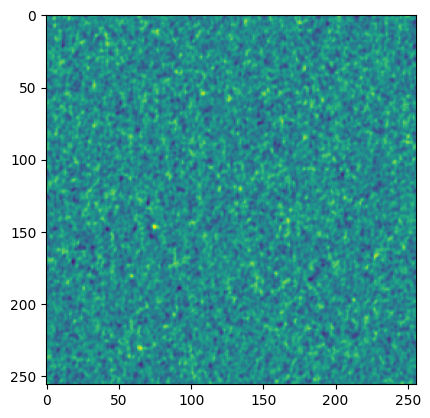

Step 100: psnr=5.422431 mse=0.286917


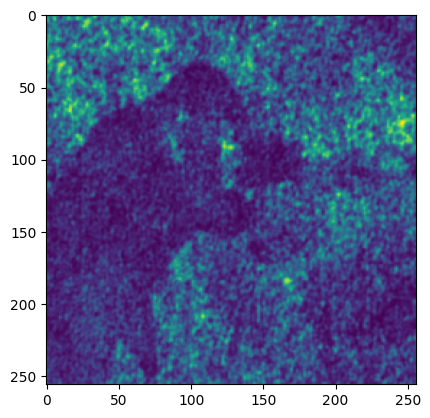

Step 200: psnr=7.448020 mse=0.179969


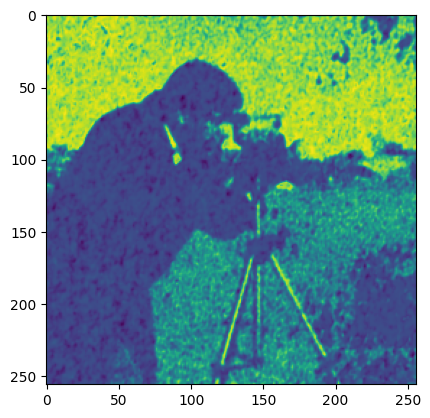

Step 300: psnr=19.725986 mse=0.010651


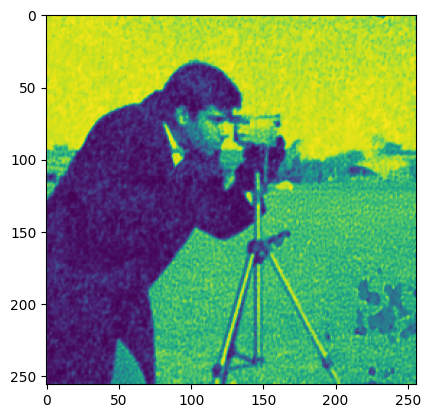

In [19]:
w2, params_shapes = train(total_steps=301, seed=0) 

Set seed=1
Step 0: psnr=4.893177 mse=0.324102


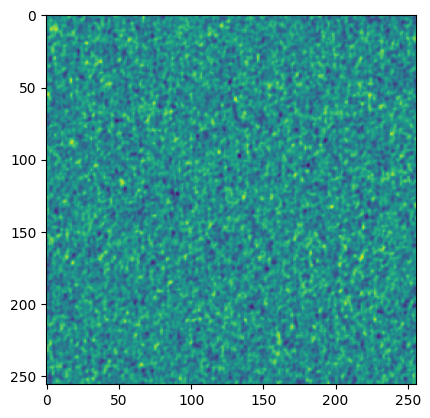

Step 100: psnr=5.477147 mse=0.283325


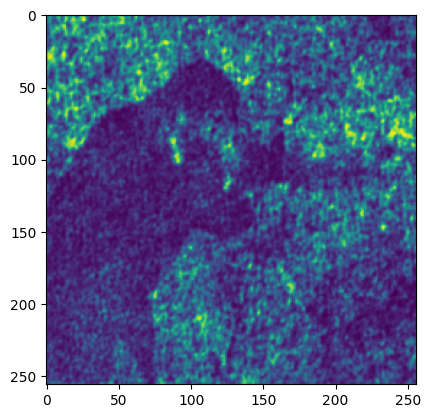

Step 200: psnr=6.964664 mse=0.201156


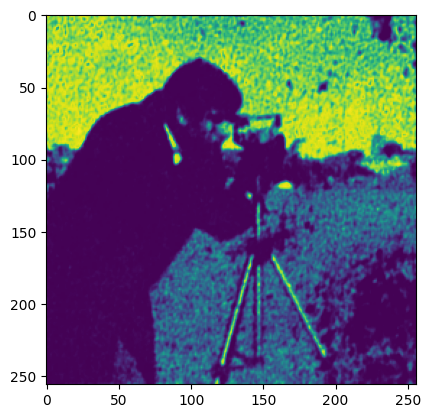

Step 300: psnr=12.728067 mse=0.053357


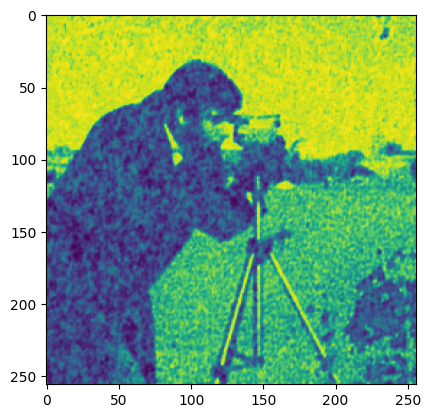

Step 400: psnr=22.760086 mse=0.005297


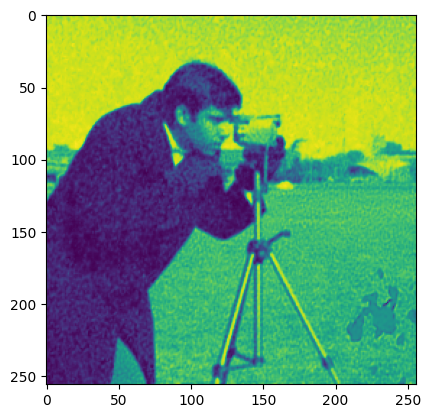

In [20]:
w3, params_shapes = train(total_steps=401, seed=1) 

In [68]:
w2, w3

(tensor[132612] x∈[-0.230, 0.240] μ=0.001 σ=0.082 grad cuda:0,
 tensor[132612] x∈[-0.260, 0.257] μ=-0.001 σ=0.084 grad cuda:0)

# Mode connectivity

$\phi$

In [21]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

In [22]:
class BezierConnectome:
    def __init__(self, w1, w2):
        self.theta = torch.randn_like(w1) * w1.std()

        self.w1 = w1
        self.w2 = w2
        
    def phi(self, t):
        return (1-t**2)*self.w1 + 2*t*(1.-t)*self.theta + t**2*self.w2

In [23]:
connectome = BezierConnectome(w2, w3)

In [24]:
connectome.theta = connectome.theta.detach()
connectome.theta.requires_grad=True
optimizer = torch.optim.AdamW([connectome.theta], lr=3e-4)

In [25]:
connectome.theta

tensor[132612] x∈[-0.361, 0.336] μ=0.000 σ=0.082 grad cuda:0

In [26]:
chunk_coords = coords[:, ::100].clone()
chunk_coords

tensor[1, 656, 2] n=1312 x∈[-1.000, 1.000] μ=-0.006 σ=0.580 cuda:0

In [27]:
def loss_for_w(w):
    loss = 0.
    n_images = 0
    correct = 0

    raw_net = param_vec2net(w, params_shapes)
    model_output = raw_net.raw_forward(chunk_coords)

    mse, psnr = mse_and_psnr(model_output, ground_truth)
    return mse

In [28]:
def ts2loss(ts):
    ws = connectome.phi(ts)
    loss = []
    for w in ws:
        loss.append(loss_for_w(w))
    return loss

In [ ]:
ts = torch.linspace(0,1, (5), device=device)[:, None]
ts

In [29]:
# losses = ts2loss(ts)
# losses

In [30]:
loss_for_w(w2), loss_for_w(w3)

(tensor grad MseLossBackward0 cuda:0 0.010,
 tensor grad MseLossBackward0 cuda:0 0.005)

In [31]:
# ts = torch.linspace(0,1, (6), device=device)[:, None]
# losses = ts2loss(ts)
# plt.plot(ts.flatten().cpu(), [l.cpu().item() for l in losses])
# # plt.ylim(0, 30)
# plt.show()

In [32]:
cbs = 4

[000] 0.18657


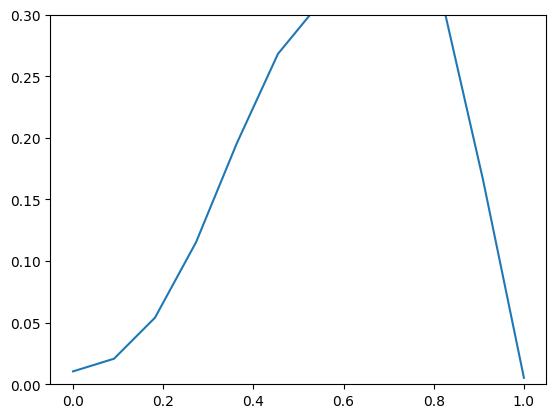

[050] 0.16947
[100] 0.17213
[150] 0.07750
[200] 0.08296
[250] 0.13689


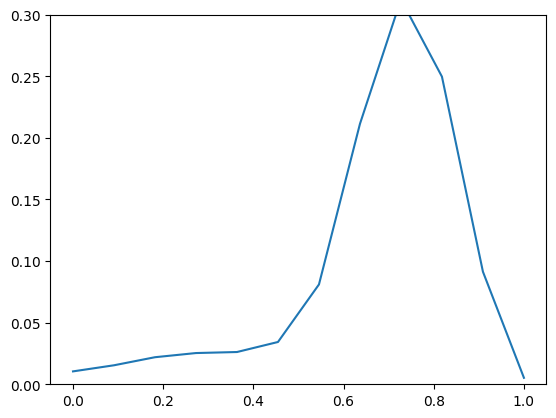

[300] 0.07417
[350] 0.08839
[400] 0.02642
[450] 0.08127
[500] 0.10946


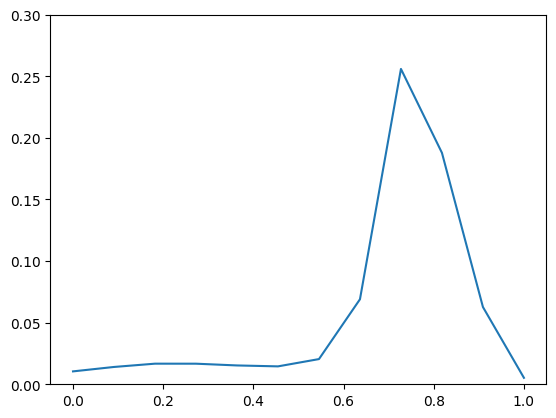

[550] 0.03892
[600] 0.03305
[650] 0.01869
[700] 0.05068
[750] 0.07090


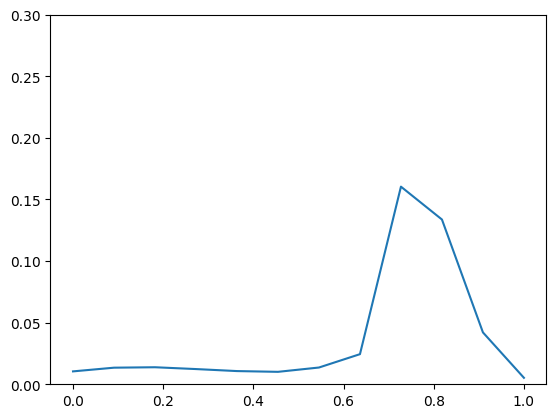

[800] 0.02429
[850] 0.07185
[900] 0.01294
[950] 0.03418
[1000] 0.00964


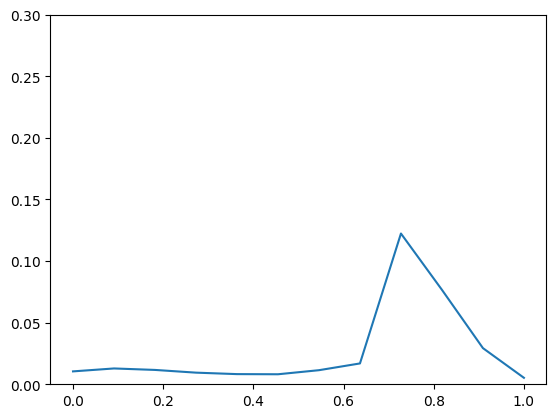

[1050] 0.03834
[1100] 0.01044
[1150] 0.02257
[1200] 0.01027
[1250] 0.07064


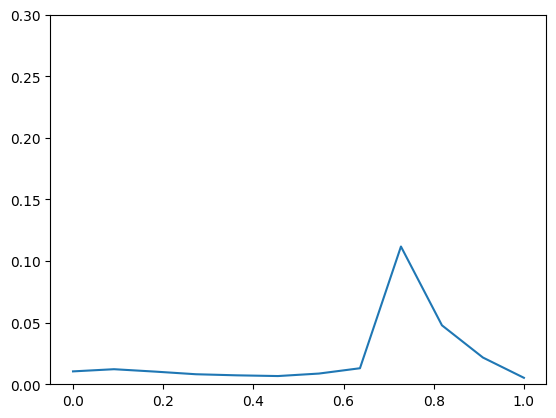

[1300] 0.04739
[1350] 0.00932
[1400] 0.00912
[1450] 0.00829
[1500] 0.00962


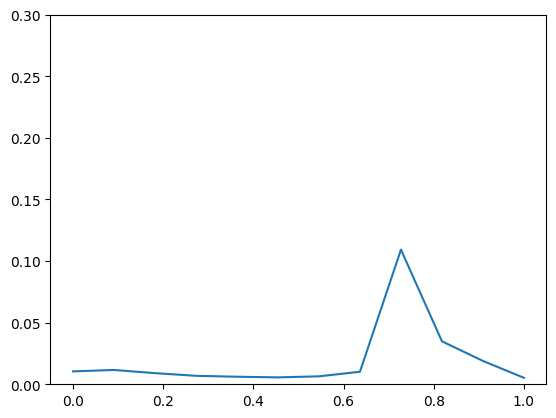

[1550] 0.01542
[1600] 0.00820
[1650] 0.03135
[1700] 0.00740
[1750] 0.01079


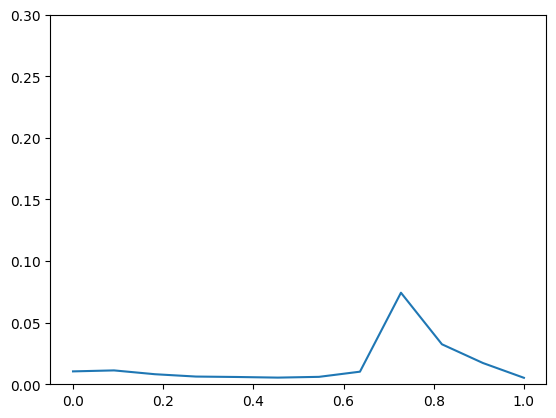

[1800] 0.00876
[1850] 0.00965
[1900] 0.03567
[1950] 0.00812
[2000] 0.00923


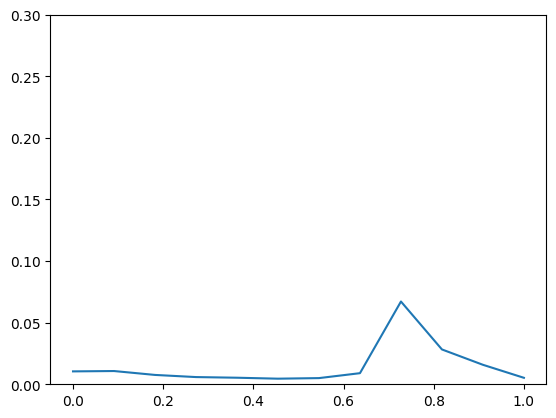

[2050] 0.00957
[2100] 0.01160
[2150] 0.02542
[2200] 0.03040
[2250] 0.00886


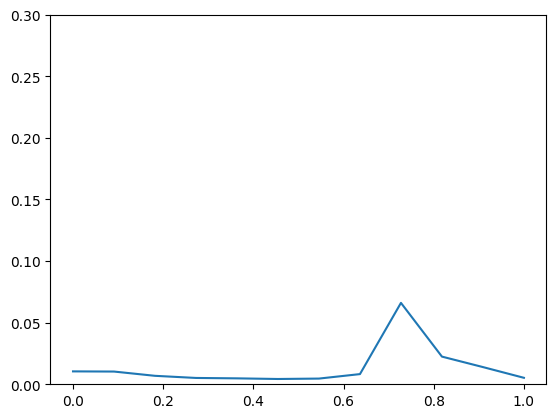

[2300] 0.01088
[2350] 0.00838
[2400] 0.00742
[2450] 0.01057
[2500] 0.03021


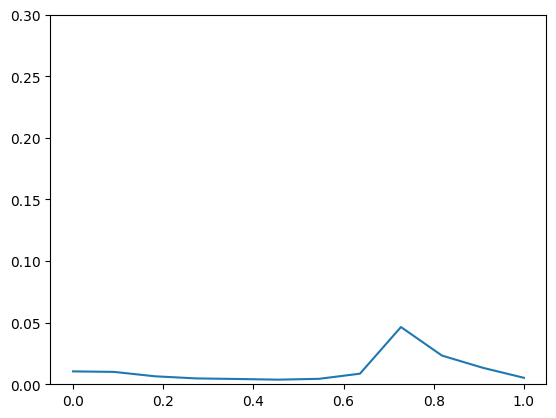

[2550] 0.03377
[2600] 0.03193
[2650] 0.00651
[2700] 0.00584
[2750] 0.03230


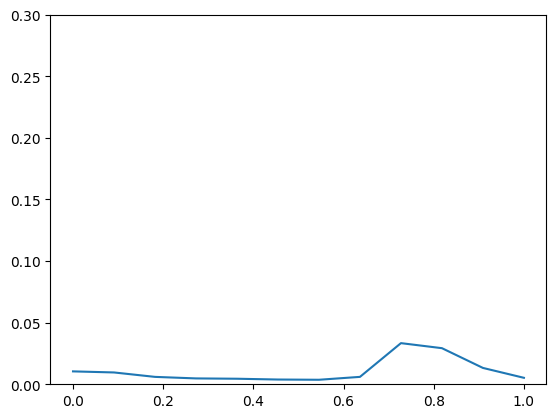

[2800] 0.00927
[2850] 0.01806
[2900] 0.00644
[2950] 0.00587
[3000] 0.03088


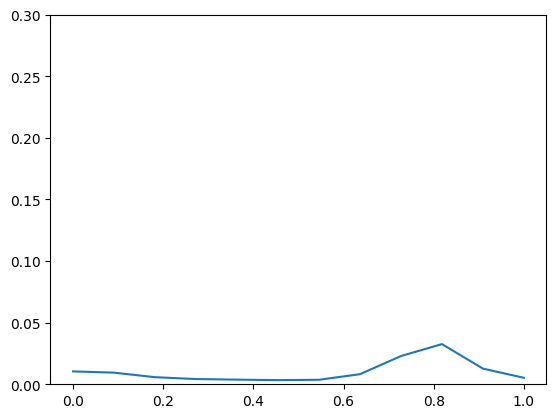

[3050] 0.01211
[3100] 0.01769
[3150] 0.00637
[3200] 0.00447
[3250] 0.00945


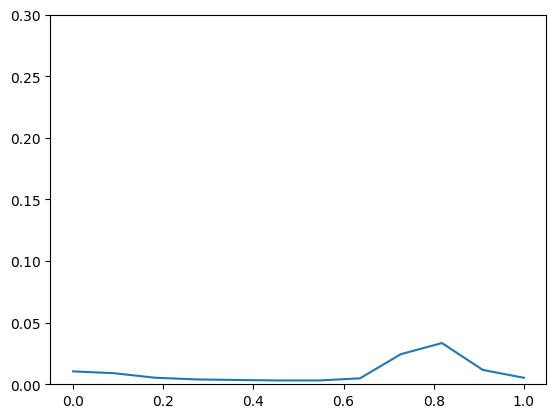

[3300] 0.00879
[3350] 0.03175
[3400] 0.01717
[3450] 0.00581
[3500] 0.01367


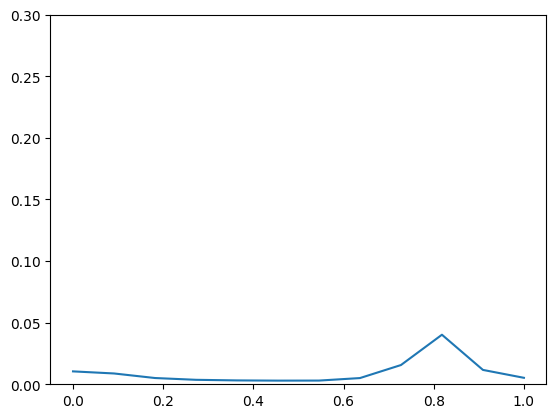

[3550] 0.00469
[3600] 0.03415
[3650] 0.00511
[3700] 0.02327
[3750] 0.00975


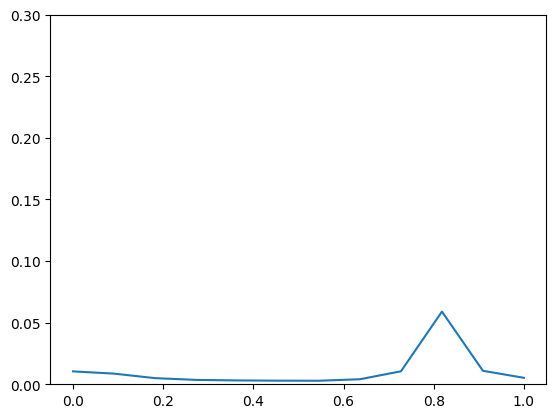

[3800] 0.02852
[3850] 0.00621
[3900] 0.02993
[3950] 0.00645
[4000] 0.01800


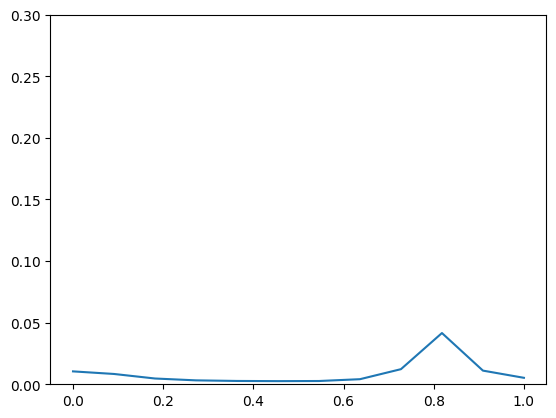

[4050] 0.00599
[4100] 0.00433
[4150] 0.00509
[4200] 0.00366
[4250] 0.00339


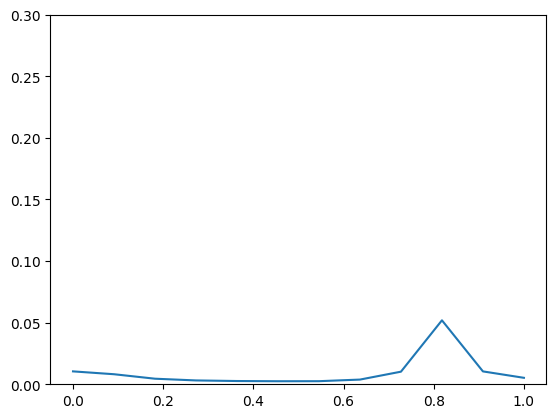

[4300] 0.00453
[4350] 0.00670
[4400] 0.00521
[4450] 0.00581
[4500] 0.00466


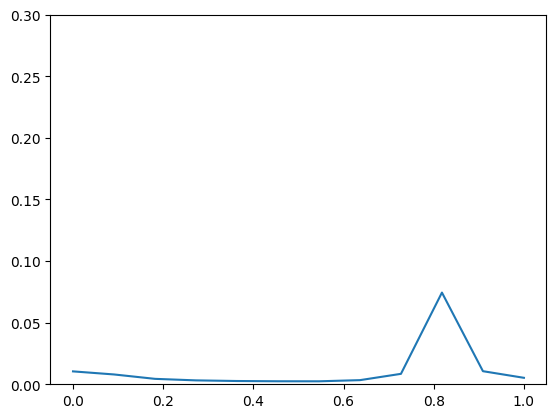

[4550] 0.01061
[4600] 0.00408
[4650] 0.00634
[4700] 0.01825
[4750] 0.00757


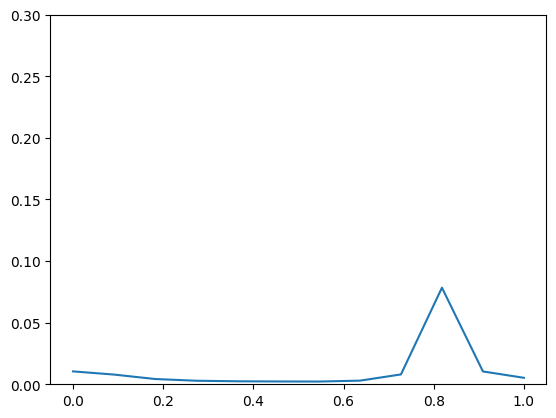

[4800] 0.00536
[4850] 0.00409
[4900] 0.02774
[4950] 0.00515
[5000] 0.00236


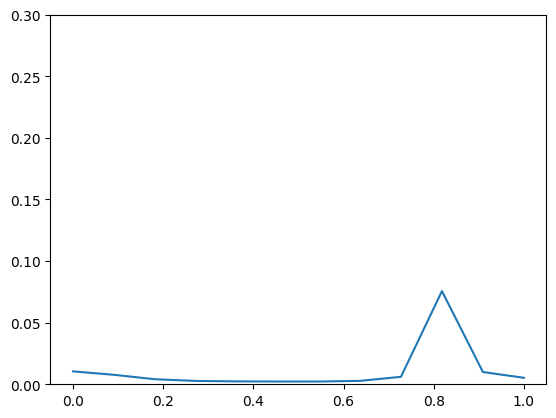

[5050] 0.00490
[5100] 0.00820
[5150] 0.00625
[5200] 0.00281
[5250] 0.00365


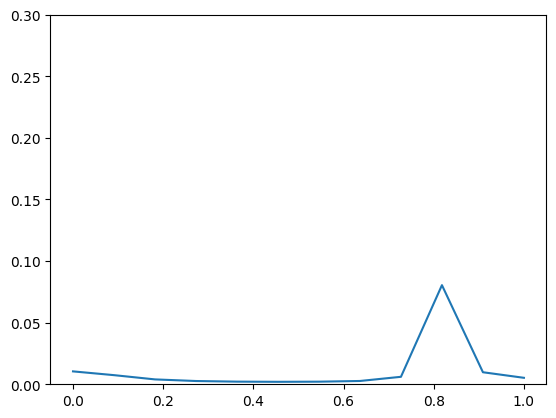

[5300] 0.02501
[5350] 0.00412
[5400] 0.00341
[5450] 0.01501
[5500] 0.01812


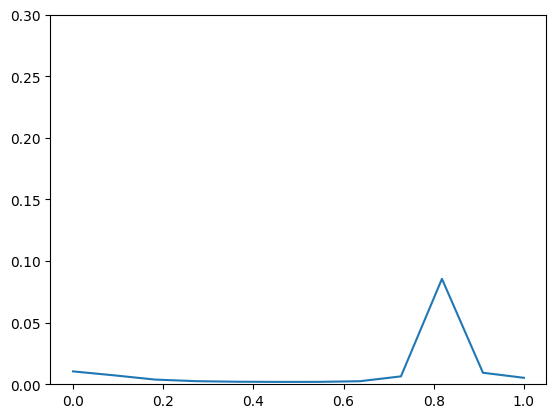

[5550] 0.00635
[5600] 0.01193
[5650] 0.00690
[5700] 0.00708
[5750] 0.00395


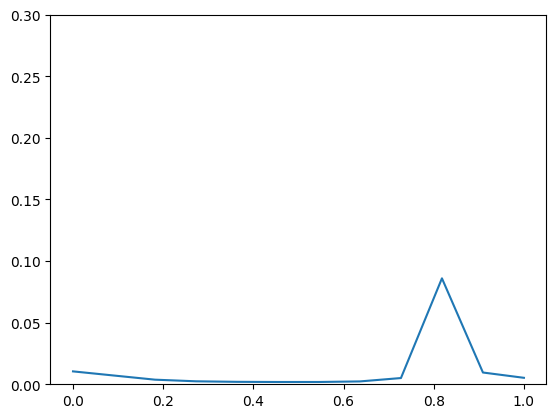

[5800] 0.00567
[5850] 0.00449
[5900] 0.01860
[5950] 0.02088
[6000] 0.00405


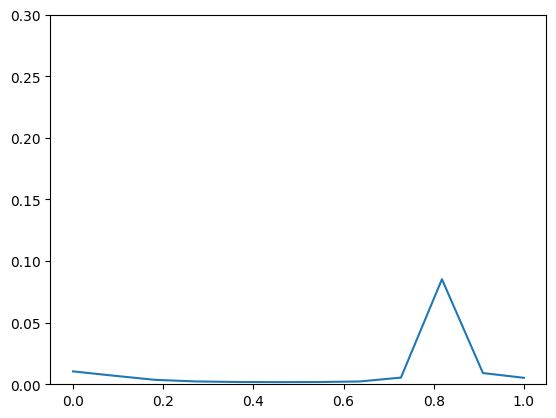

[6050] 0.00652
[6100] 0.00320
[6150] 0.00810
[6200] 0.02302
[6250] 0.01324


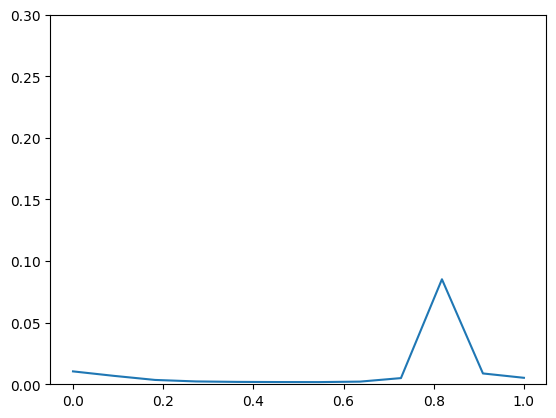

[6300] 0.01236
[6350] 0.00424
[6400] 0.00620
[6450] 0.00354
[6500] 0.00472


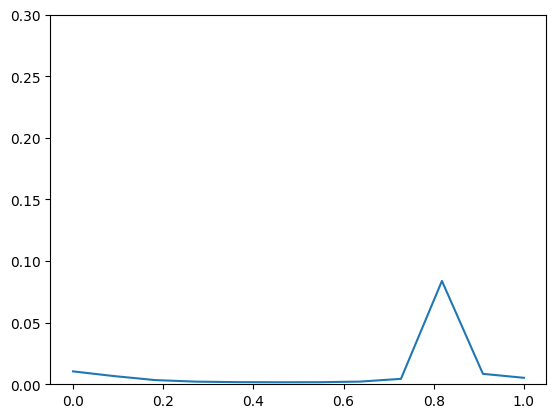

[6550] 0.00214
[6600] 0.00361
[6650] 0.00478
[6700] 0.01029
[6750] 0.00288


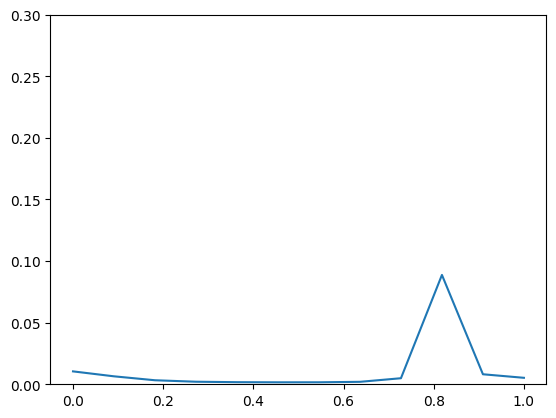

[6800] 0.02656
[6850] 0.00315
[6900] 0.00392
[6950] 0.00372
[7000] 0.00484


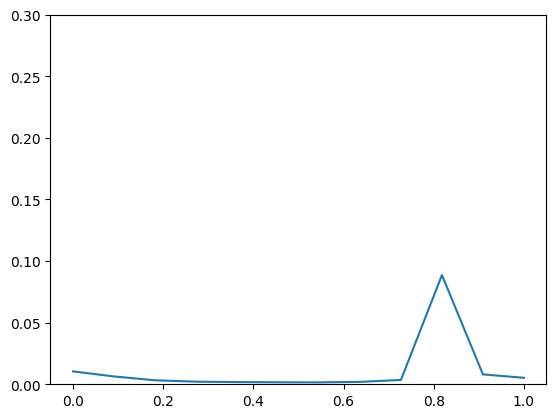

[7050] 0.00277
[7100] 0.02158
[7150] 0.00333
[7200] 0.00345
[7250] 0.00353


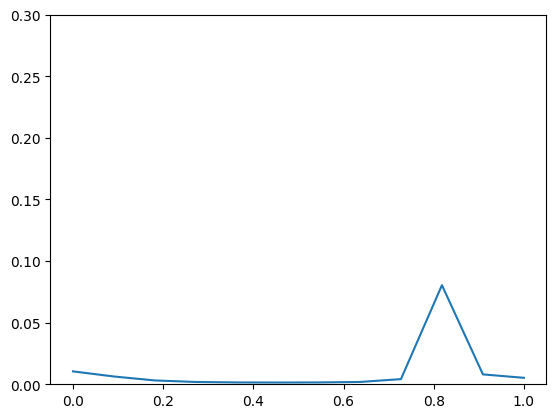

[7300] 0.02084
[7350] 0.00170
[7400] 0.00235
[7450] 0.00503
[7500] 0.00358


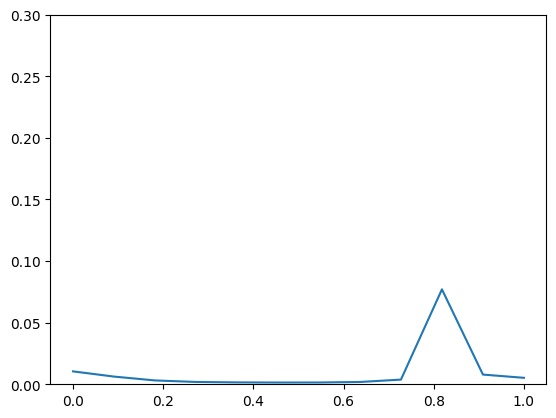

[7550] 0.00710
[7600] 0.00388
[7650] 0.01091
[7700] 0.00261
[7750] 0.00175


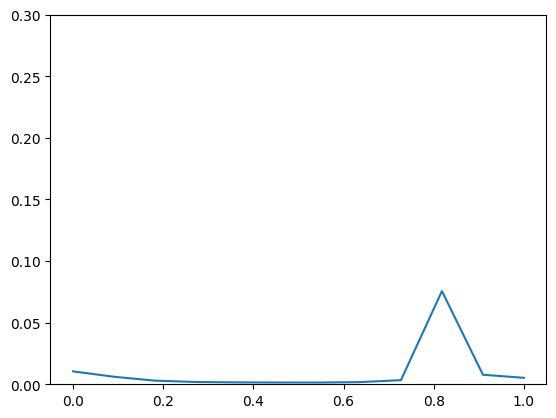

[7800] 0.00315
[7850] 0.00260
[7900] 0.00155
[7950] 0.02607
[8000] 0.00568


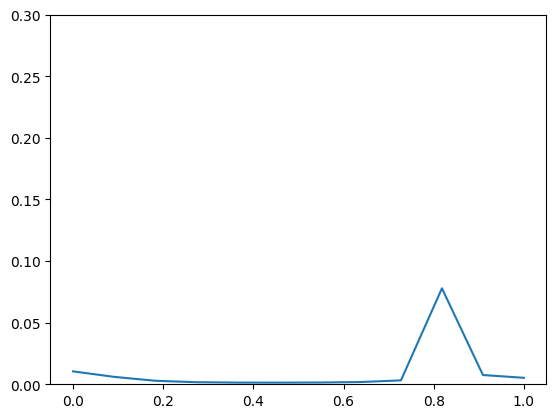

[8050] 0.00740
[8100] 0.01763
[8150] 0.00255
[8200] 0.00484
[8250] 0.00250


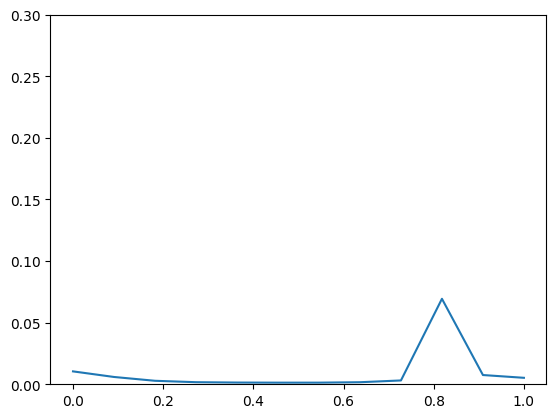

[8300] 0.00224
[8350] 0.00166
[8400] 0.00285
[8450] 0.00587
[8500] 0.00422


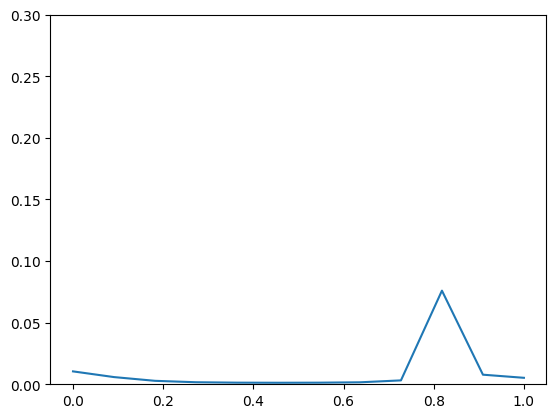

[8550] 0.00483
[8600] 0.00291
[8650] 0.00433
[8700] 0.00303
[8750] 0.01075


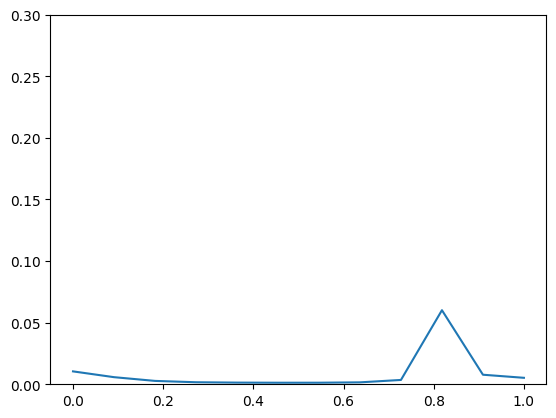

[8800] 0.00357
[8850] 0.00287
[8900] 0.00322
[8950] 0.00460
[9000] 0.00314


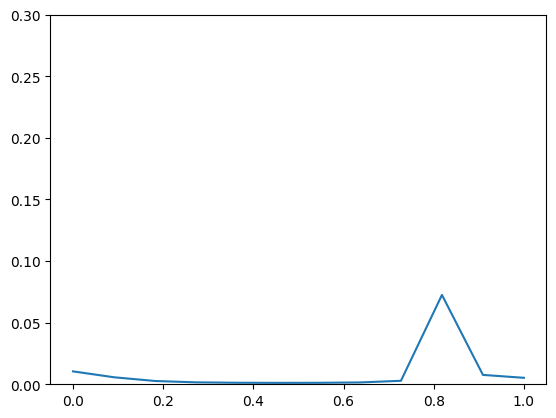

[9050] 0.00365
[9100] 0.00371
[9150] 0.00114
[9200] 0.01985
[9250] 0.00294


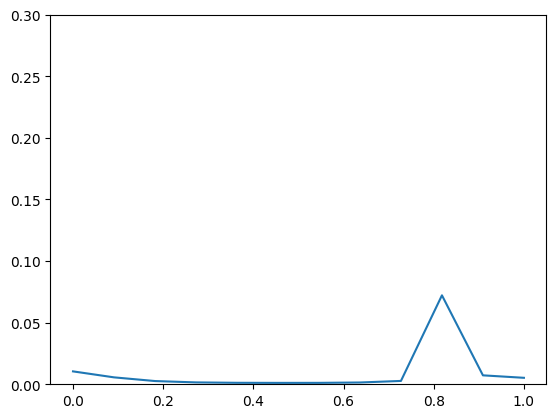

[9300] 0.00209
[9350] 0.01068
[9400] 0.00593
[9450] 0.02107
[9500] 0.00943


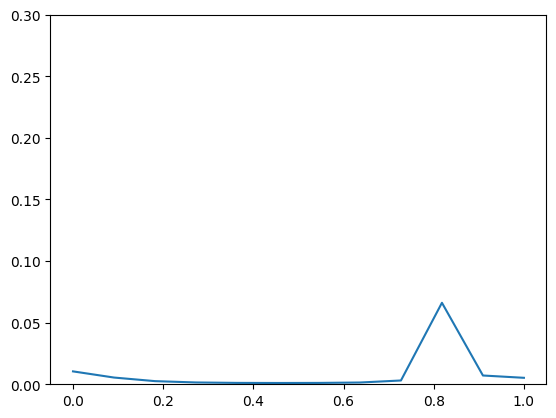

[9550] 0.00204
[9600] 0.00296
[9650] 0.01803
[9700] 0.00225
[9750] 0.00246


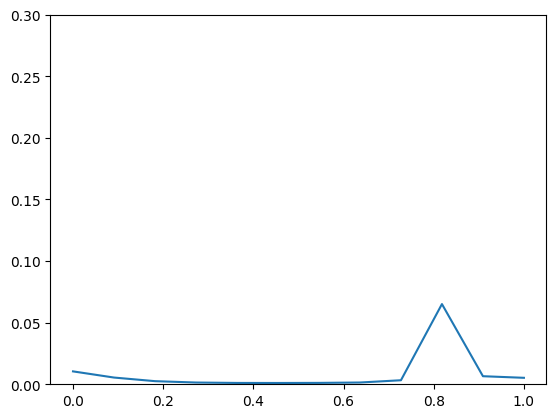

[9800] 0.00106
[9850] 0.00209
[9900] 0.01459
[9950] 0.00221
[10000] 0.00640


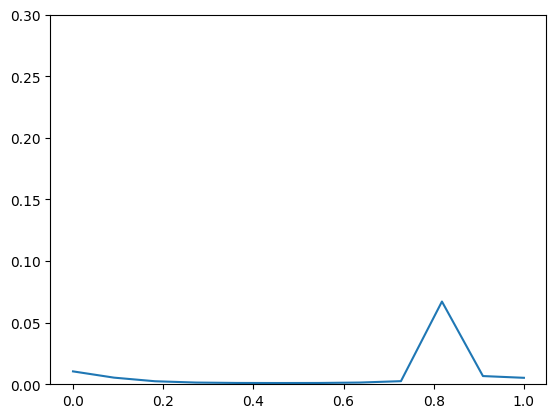

[10050] 0.00450
[10100] 0.00464
[10150] 0.00387
[10200] 0.00383
[10250] 0.00251


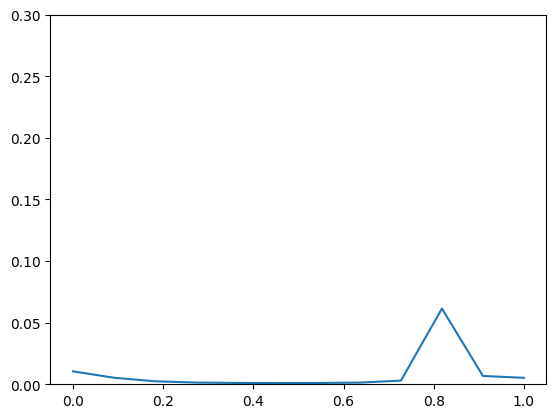

[10300] 0.00276
[10350] 0.01605
[10400] 0.00370
[10450] 0.00426
[10500] 0.00832


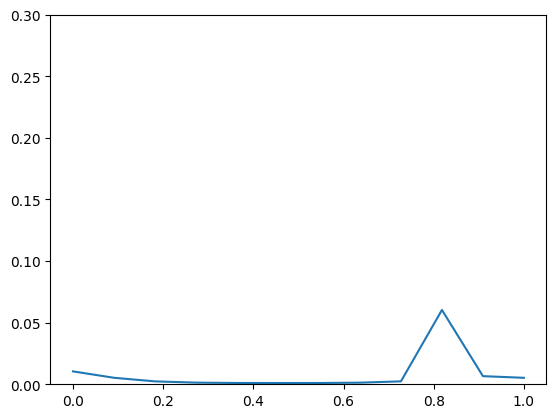

[10550] 0.00119
[10600] 0.00670
[10650] 0.00912
[10700] 0.01160
[10750] 0.00737


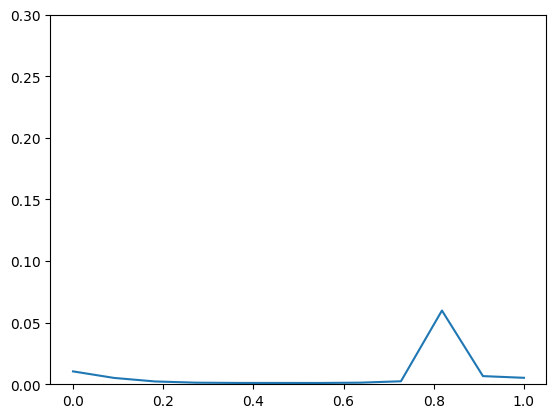

[10800] 0.00364
[10850] 0.00115
[10900] 0.01548
[10950] 0.00236
[11000] 0.00615


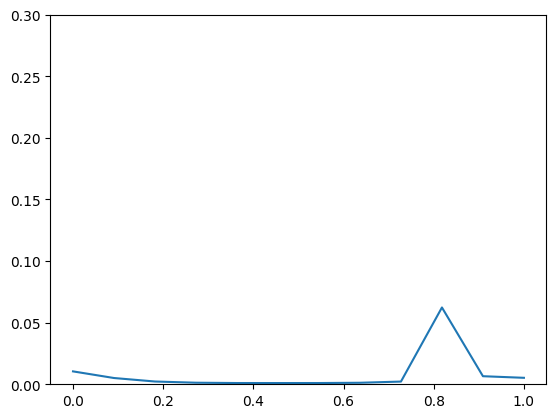

[11050] 0.00254
[11100] 0.00125
[11150] 0.00217
[11200] 0.00241
[11250] 0.00198


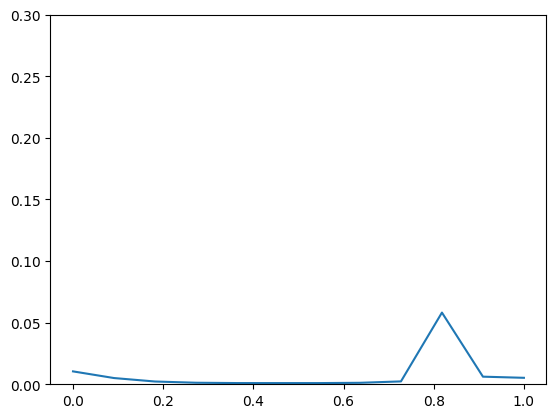

[11300] 0.00183
[11350] 0.00192
[11400] 0.00396
[11450] 0.00498
[11500] 0.00403


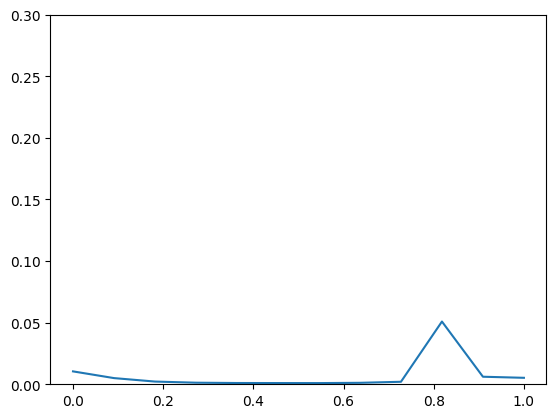

[11550] 0.00578
[11600] 0.01619
[11650] 0.00370
[11700] 0.00280
[11750] 0.01624


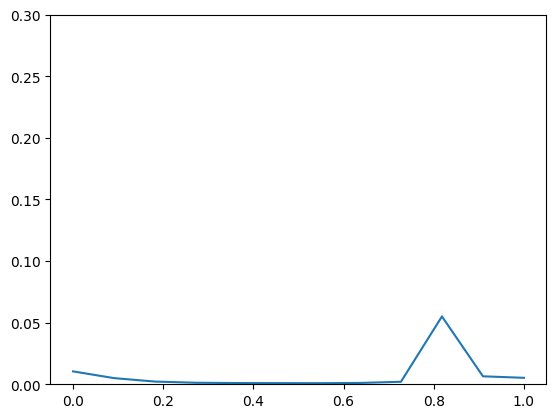

[11800] 0.01253
[11850] 0.01123
[11900] 0.00176
[11950] 0.00124
[12000] 0.00242


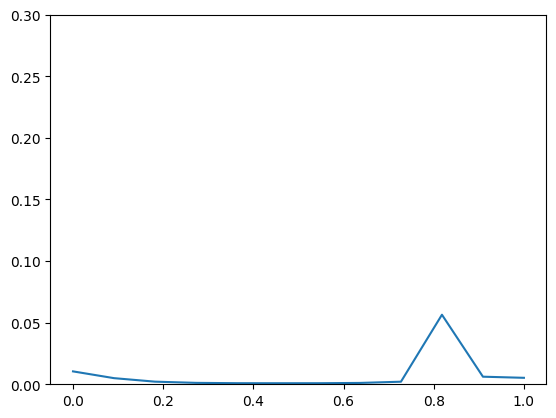

[12050] 0.00208
[12100] 0.01201
[12150] 0.00098
[12200] 0.00460
[12250] 0.00357


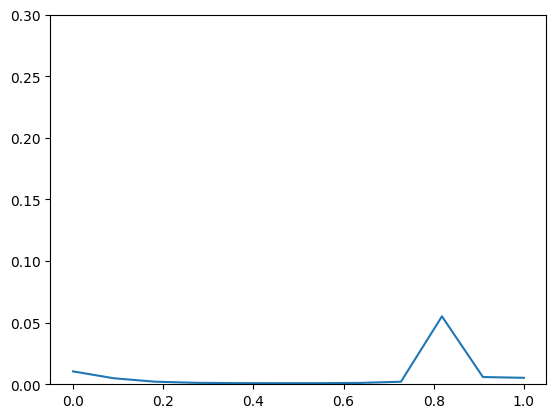

[12300] 0.01235
[12350] 0.00113
[12400] 0.00206
[12450] 0.00295
[12500] 0.00231


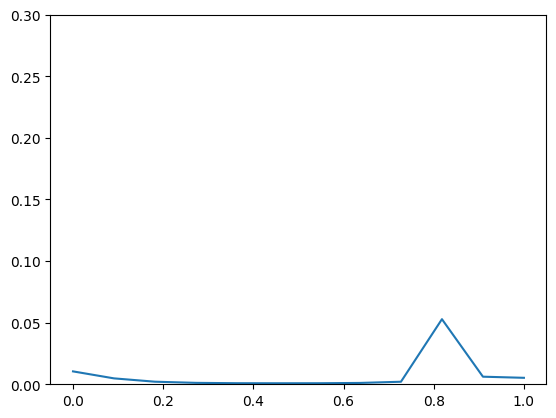

[12550] 0.00217
[12600] 0.00421
[12650] 0.00798
[12700] 0.00264
[12750] 0.00302


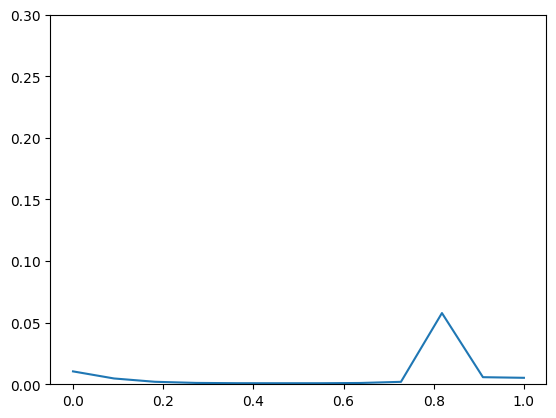

[12800] 0.01518
[12850] 0.00339
[12900] 0.00206
[12950] 0.00443
[13000] 0.01515


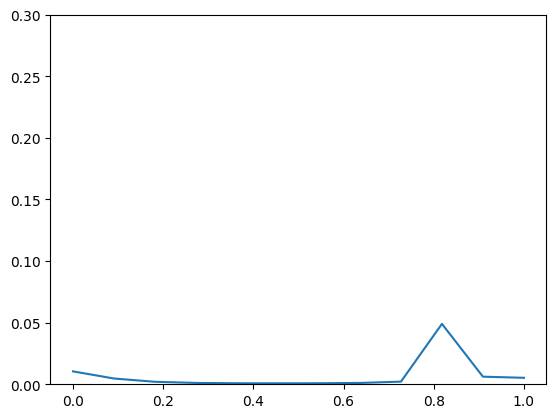

[13050] 0.00232
[13100] 0.00373
[13150] 0.01338
[13200] 0.00683
[13250] 0.00353


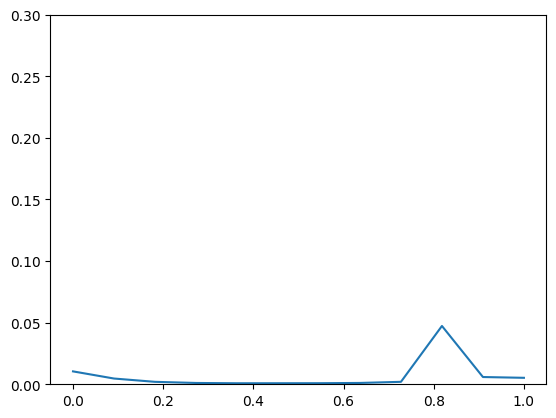

[13300] 0.00283
[13350] 0.00254
[13400] 0.00094
[13450] 0.00095
[13500] 0.00375


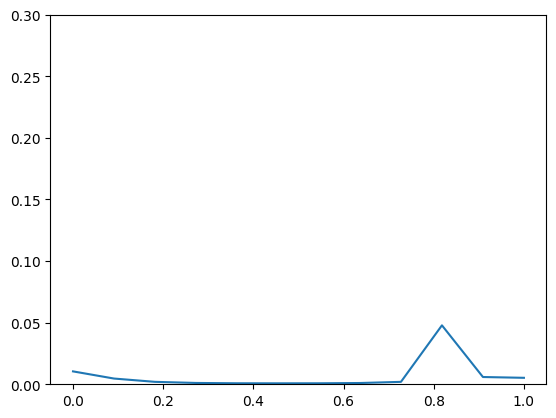

[13550] 0.00354
[13600] 0.00232
[13650] 0.00214
[13700] 0.00497
[13750] 0.00257


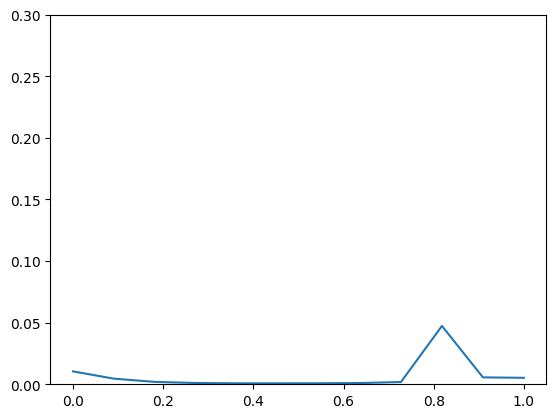

[13800] 0.00300
[13850] 0.00268
[13900] 0.00239
[13950] 0.00230
[14000] 0.00474


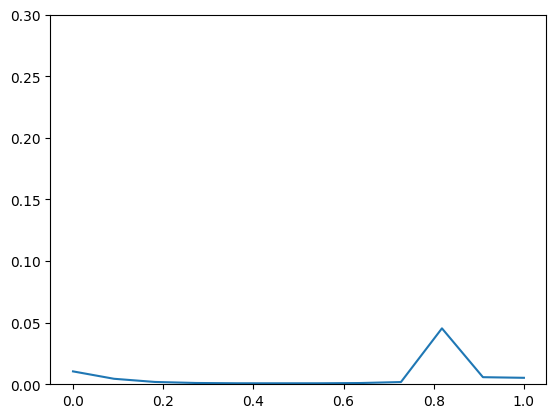

[14050] 0.01139
[14100] 0.00591
[14150] 0.01602
[14200] 0.00365
[14250] 0.00214


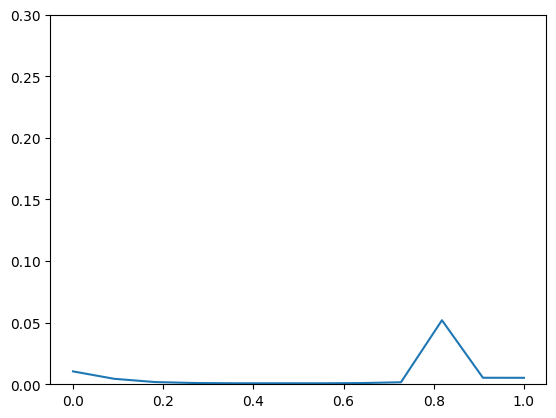

[14300] 0.00483
[14350] 0.00386
[14400] 0.00557
[14450] 0.00498
[14500] 0.00320


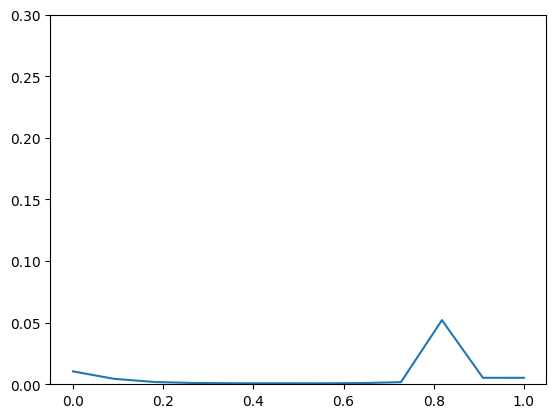

[14550] 0.00289
[14600] 0.00207
[14650] 0.00467
[14700] 0.00168
[14750] 0.00113


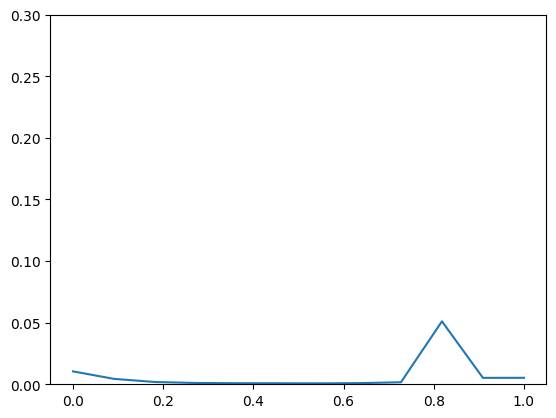

[14800] 0.00342
[14850] 0.00240
[14900] 0.00136
[14950] 0.01832
[15000] 0.00313


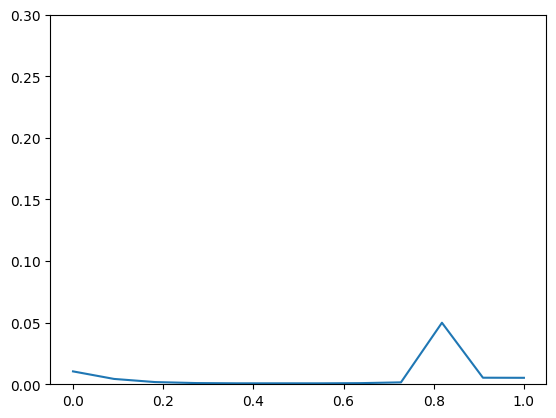

[15050] 0.00841
[15100] 0.00115
[15150] 0.00434
[15200] 0.00091
[15250] 0.00424


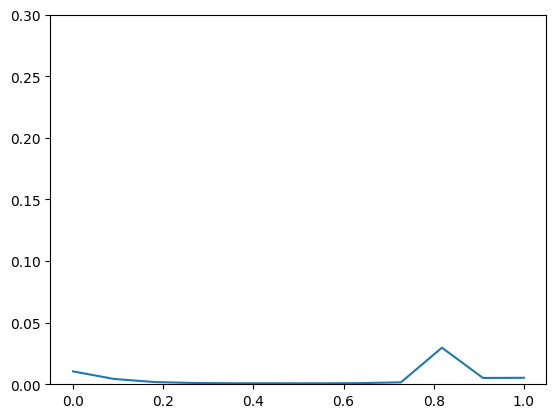

[15300] 0.00820
[15350] 0.00321
[15400] 0.00330
[15450] 0.00247
[15500] 0.00943


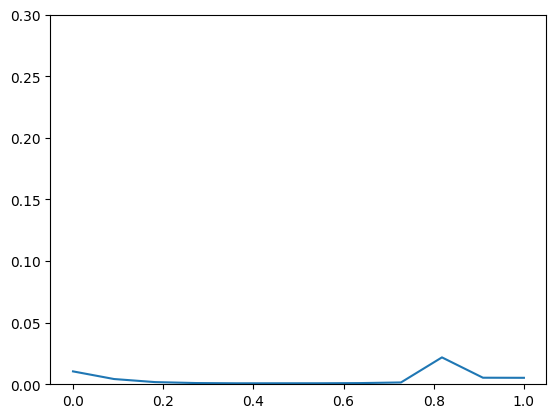

[15550] 0.00122
[15600] 0.00873
[15650] 0.02175
[15700] 0.01017
[15750] 0.00217


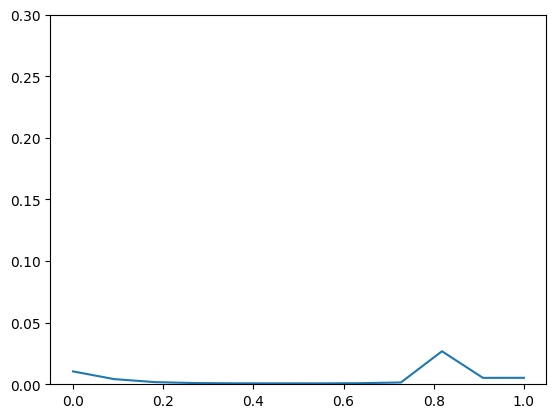

[15800] 0.00169
[15850] 0.01259
[15900] 0.00152
[15950] 0.01182
[16000] 0.01069


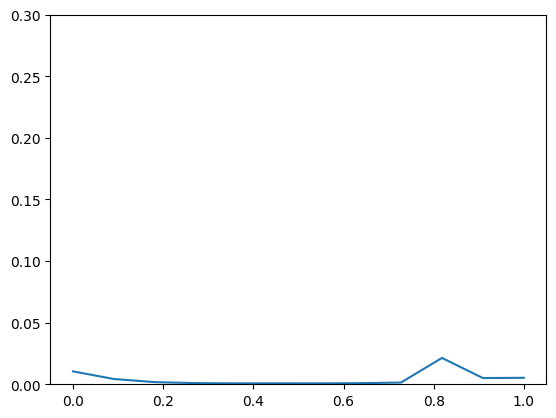

[16050] 0.00205
[16100] 0.00178
[16150] 0.00319
[16200] 0.00308
[16250] 0.00177


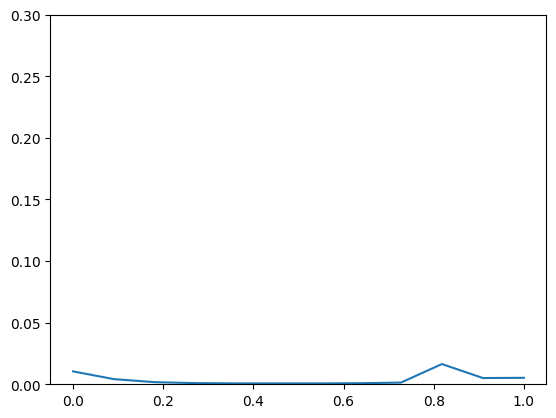

[16300] 0.00290
[16350] 0.01656
[16400] 0.00141
[16450] 0.00205
[16500] 0.00265


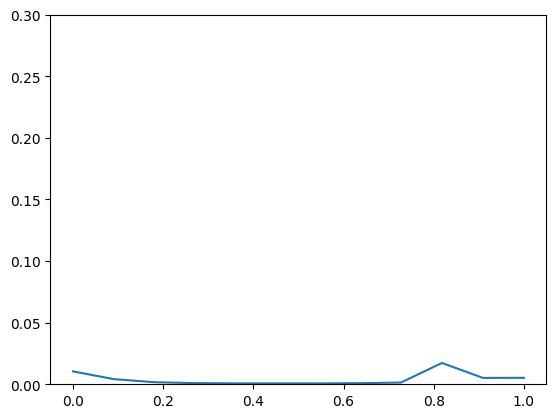

[16550] 0.00194
[16600] 0.00077
[16650] 0.00200
[16700] 0.00287
[16750] 0.00275


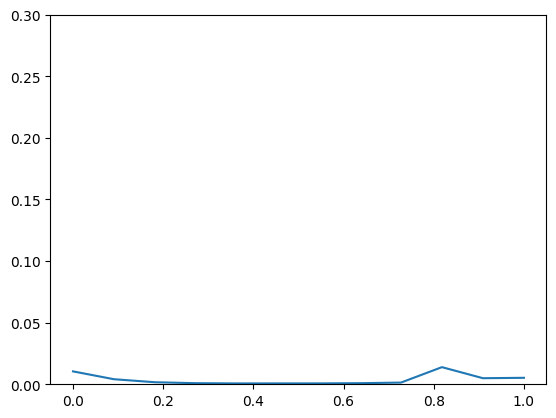

[16800] 0.00464
[16850] 0.00201
[16900] 0.00129
[16950] 0.00525
[17000] 0.00260


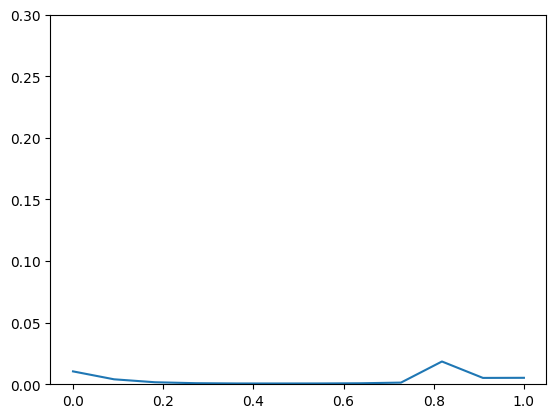

[17050] 0.00114
[17100] 0.00632
[17150] 0.00332
[17200] 0.00329
[17250] 0.00217


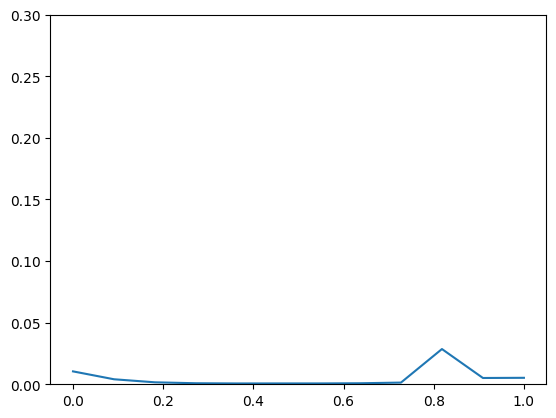

[17300] 0.00279
[17350] 0.00204
[17400] 0.00148
[17450] 0.00065
[17500] 0.01171


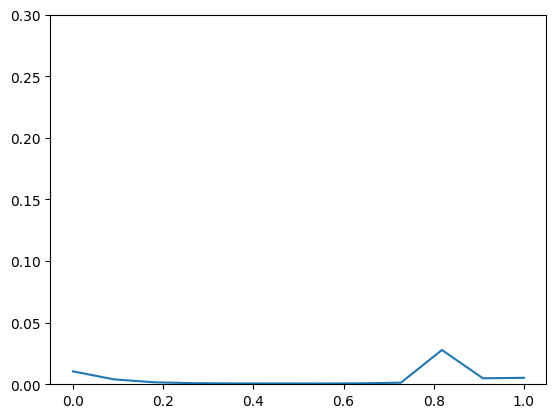

[17550] 0.00199
[17600] 0.00226
[17650] 0.01165
[17700] 0.00601
[17750] 0.00111


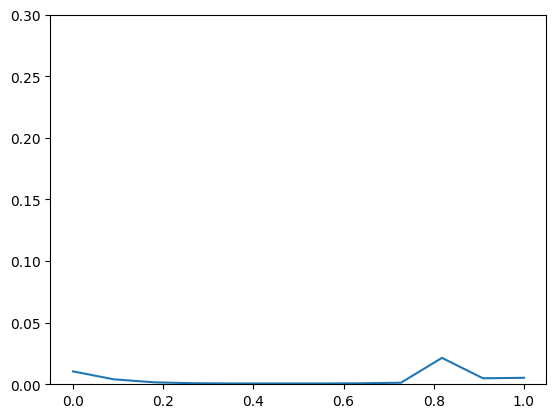

[17800] 0.00408
[17850] 0.00149
[17900] 0.01265
[17950] 0.00428
[18000] 0.01236


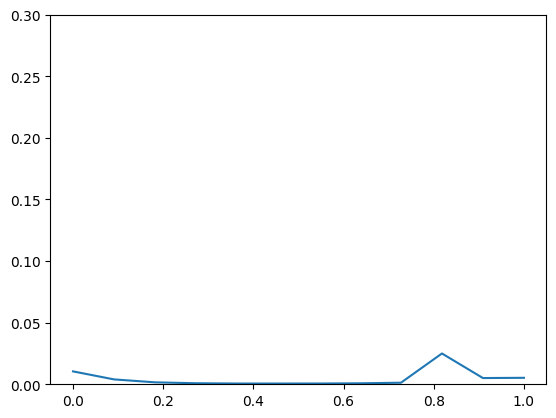

[18050] 0.00758
[18100] 0.00081
[18150] 0.00225
[18200] 0.00094
[18250] 0.00259


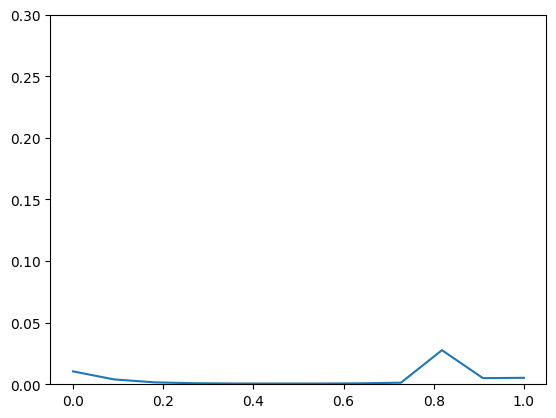

[18300] 0.00125
[18350] 0.00100
[18400] 0.00325
[18450] 0.00548
[18500] 0.00253


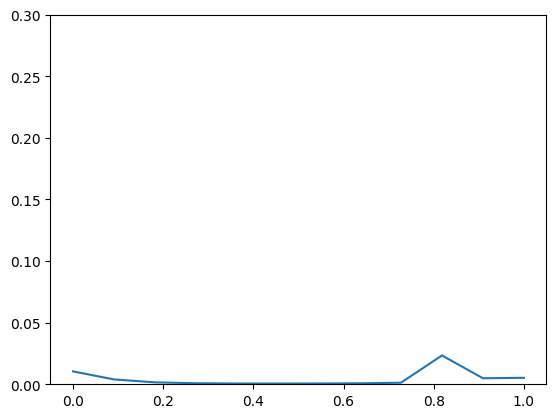

[18550] 0.00287
[18600] 0.00112
[18650] 0.00094
[18700] 0.00264
[18750] 0.00228


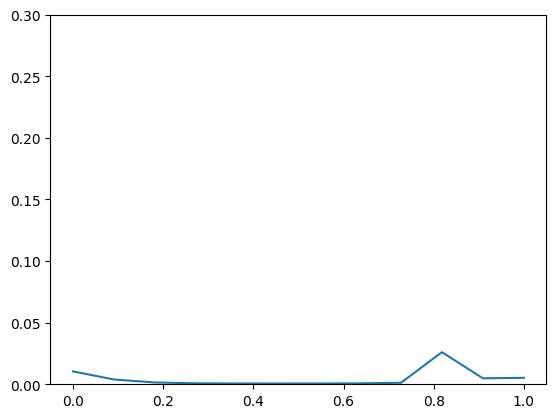

[18800] 0.00310
[18850] 0.00082
[18900] 0.00398
[18950] 0.00073
[19000] 0.00190


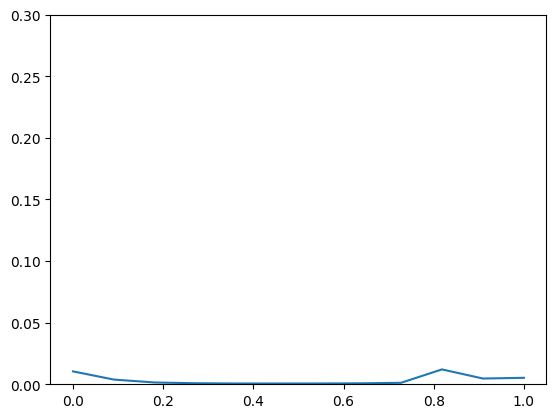

[19050] 0.00078
[19100] 0.01930
[19150] 0.00105
[19200] 0.00328
[19250] 0.00295


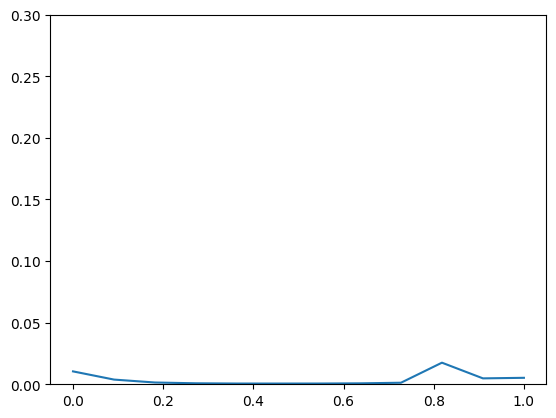

[19300] 0.00382
[19350] 0.00394
[19400] 0.00245
[19450] 0.00202
[19500] 0.00239


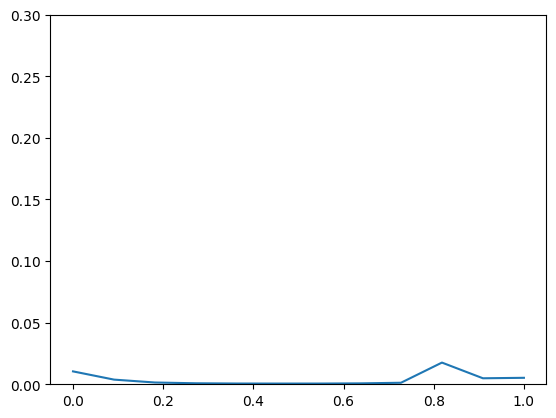

[19550] 0.00363
[19600] 0.01018
[19650] 0.00175
[19700] 0.00290
[19750] 0.01263


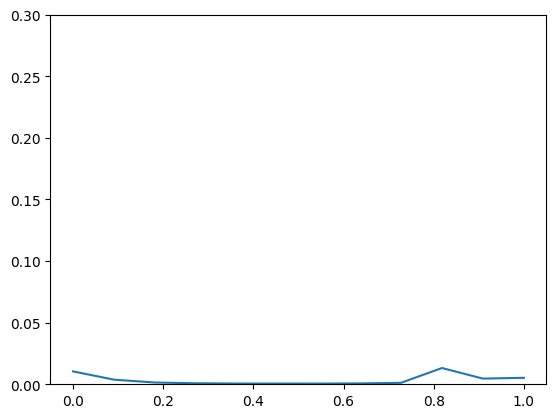

[19800] 0.00328
[19850] 0.00100
[19900] 0.00072
[19950] 0.00173
[20000] 0.00133


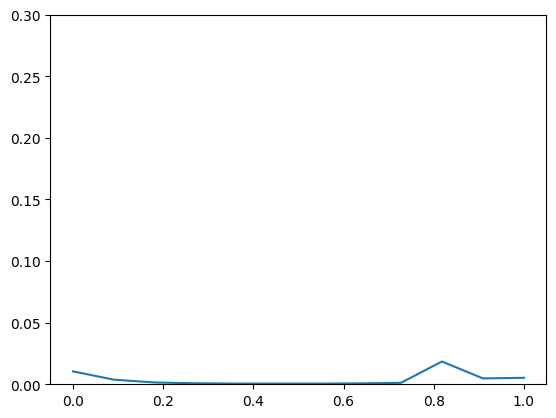

[20050] 0.00391
[20100] 0.00210
[20150] 0.00449
[20200] 0.00122
[20250] 0.00220


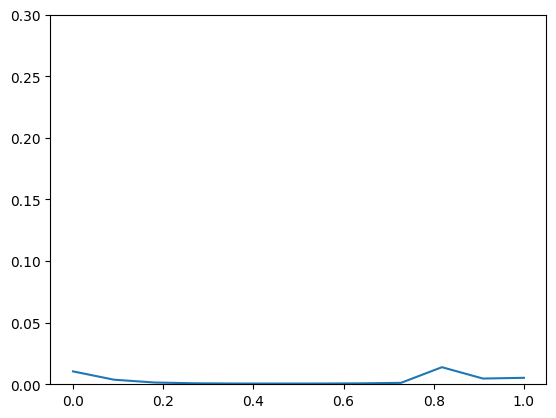

[20300] 0.01110
[20350] 0.01019
[20400] 0.00201
[20450] 0.01024
[20500] 0.00750


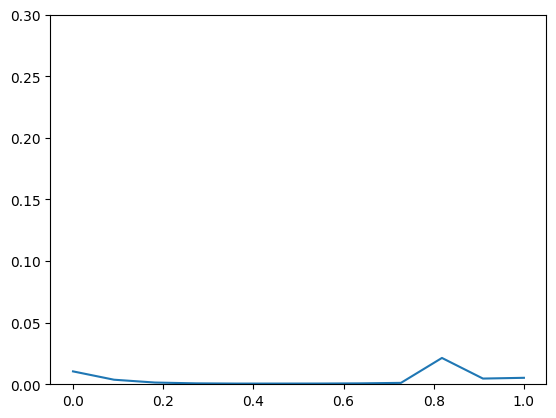

[20550] 0.00086
[20600] 0.00139
[20650] 0.00280
[20700] 0.00345
[20750] 0.00231


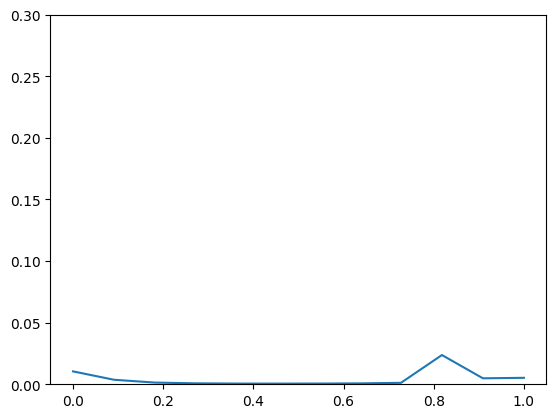

[20800] 0.00126
[20850] 0.01569
[20900] 0.00206
[20950] 0.00462
[21000] 0.00861


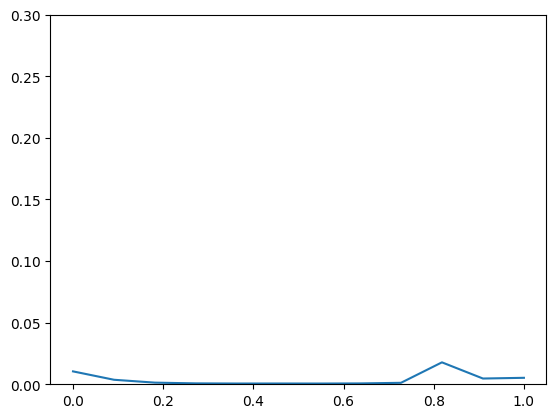

[21050] 0.00335
[21100] 0.00175
[21150] 0.00062
[21200] 0.00168
[21250] 0.00444


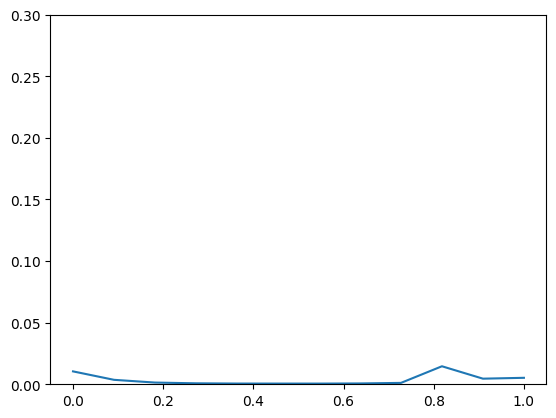

[21300] 0.00135
[21350] 0.00335
[21400] 0.00266
[21450] 0.00629
[21500] 0.00165


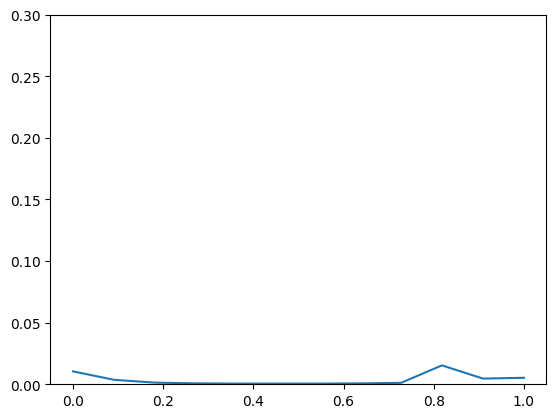

[21550] 0.00192
[21600] 0.00630
[21650] 0.00189
[21700] 0.00294
[21750] 0.00419


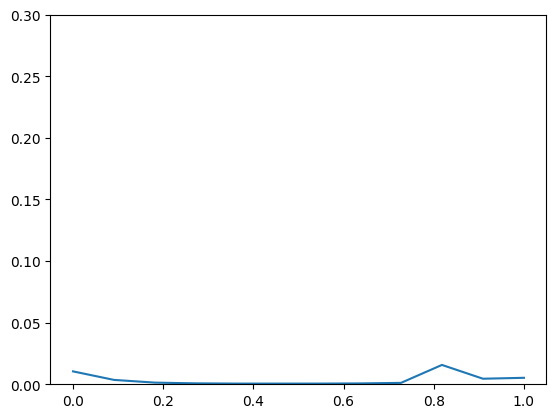

[21800] 0.00252
[21850] 0.00113
[21900] 0.00429
[21950] 0.00121
[22000] 0.00213


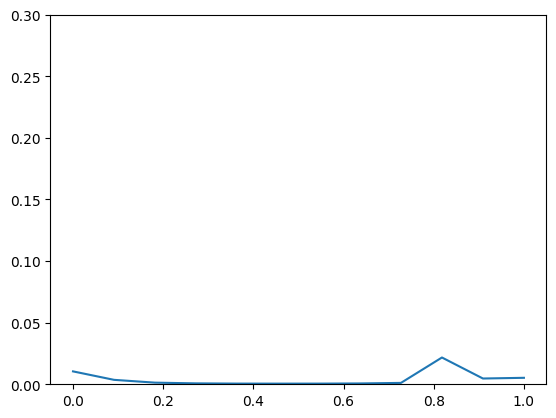

[22050] 0.00181
[22100] 0.00241
[22150] 0.00075
[22200] 0.00093
[22250] 0.00267


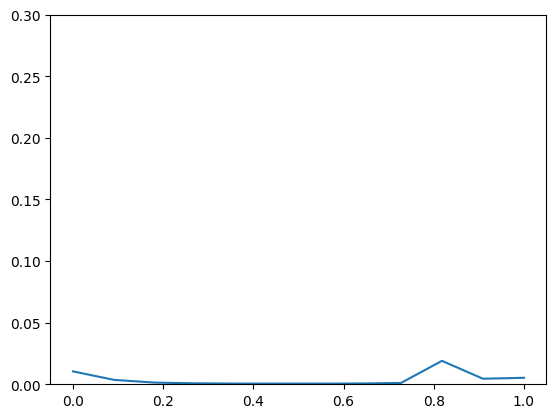

[22300] 0.00059
[22350] 0.00186
[22400] 0.00097
[22450] 0.00190
[22500] 0.00166


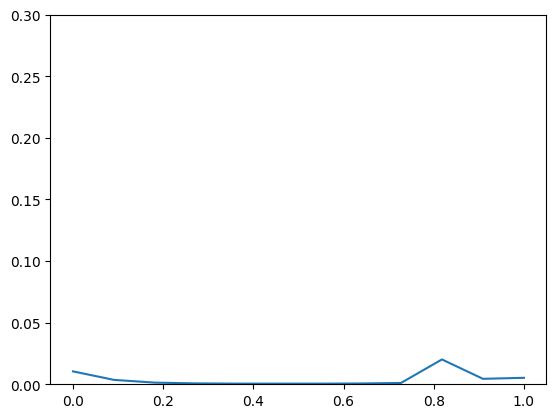

[22550] 0.00264
[22600] 0.00149
[22650] 0.00282
[22700] 0.00186
[22750] 0.00979


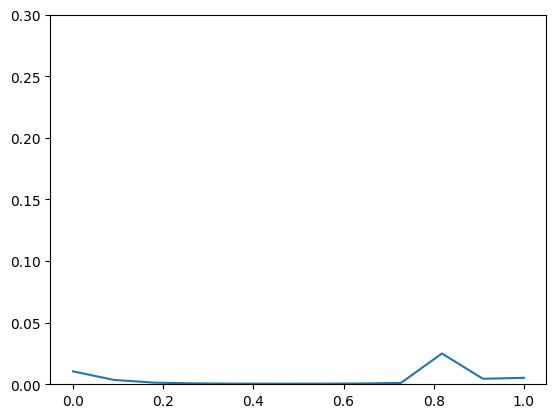

[22800] 0.00434
[22850] 0.00059
[22900] 0.01464
[22950] 0.01047
[23000] 0.00131


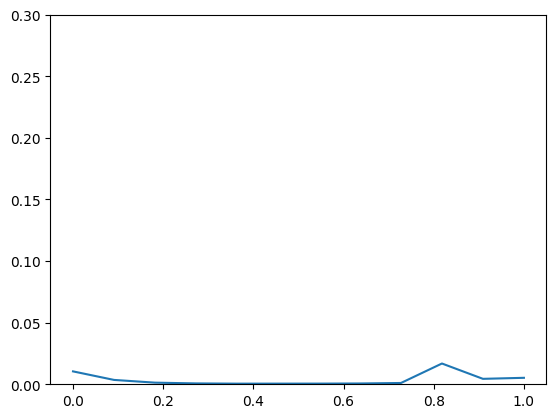

[23050] 0.00395
[23100] 0.00228
[23150] 0.00366
[23200] 0.00123
[23250] 0.00234


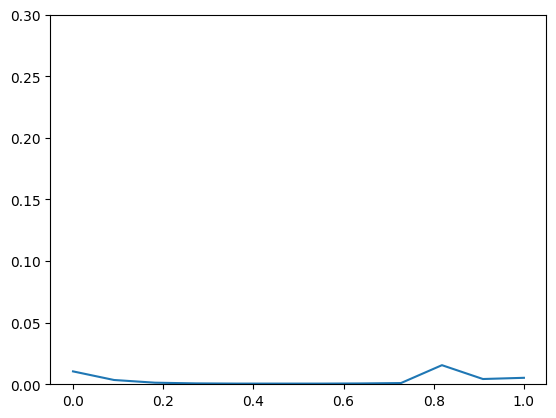

[23300] 0.00376
[23350] 0.01206
[23400] 0.00150
[23450] 0.00434
[23500] 0.00181


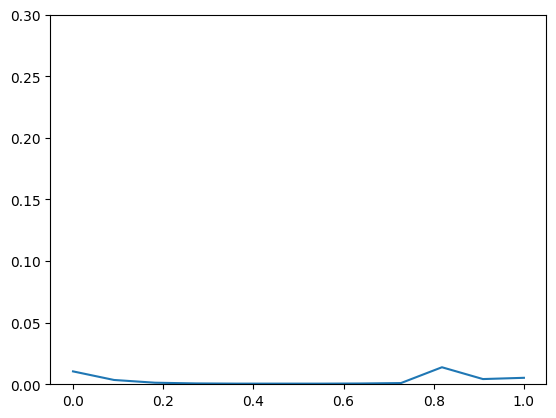

[23550] 0.00137
[23600] 0.00162
[23650] 0.00182
[23700] 0.00428
[23750] 0.01041


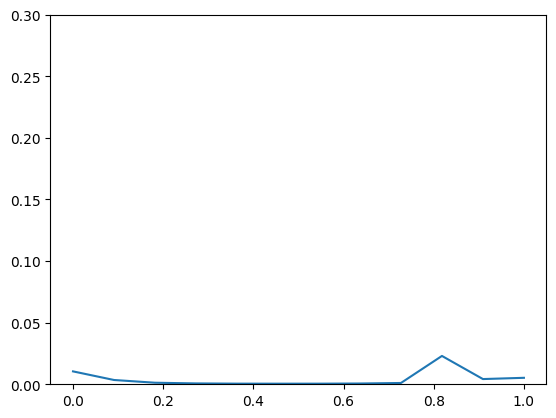

[23800] 0.00126
[23850] 0.01082
[23900] 0.00070
[23950] 0.00968
[24000] 0.00114


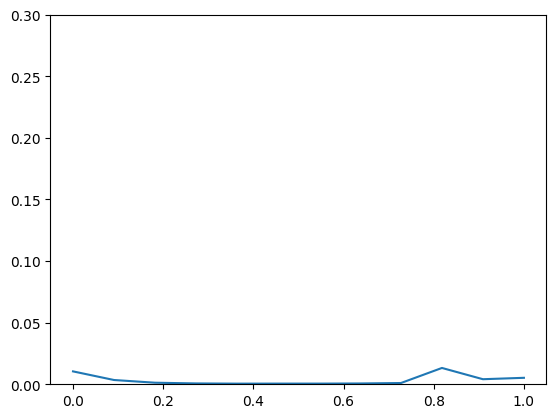

[24050] 0.00247
[24100] 0.00324
[24150] 0.00433
[24200] 0.00470
[24250] 0.00758


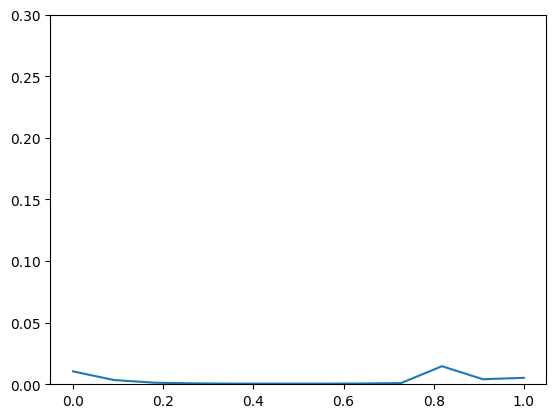

[24300] 0.00173
[24350] 0.00236
[24400] 0.00446
[24450] 0.00083
[24500] 0.01029


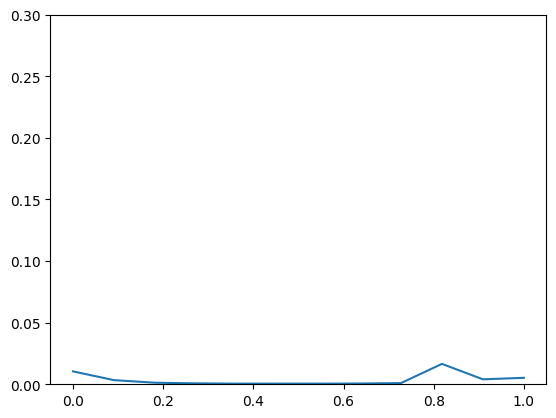

[24550] 0.00246
[24600] 0.00909
[24650] 0.00247
[24700] 0.00150
[24750] 0.00219


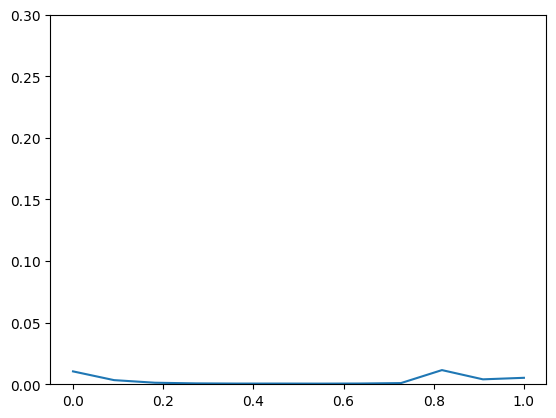

[24800] 0.00309
[24850] 0.00937
[24900] 0.00322
[24950] 0.00064
[25000] 0.00156


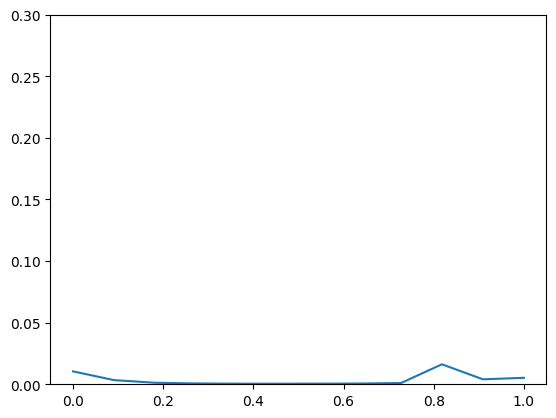

[25050] 0.00077
[25100] 0.00746
[25150] 0.00473
[25200] 0.00064
[25250] 0.00224


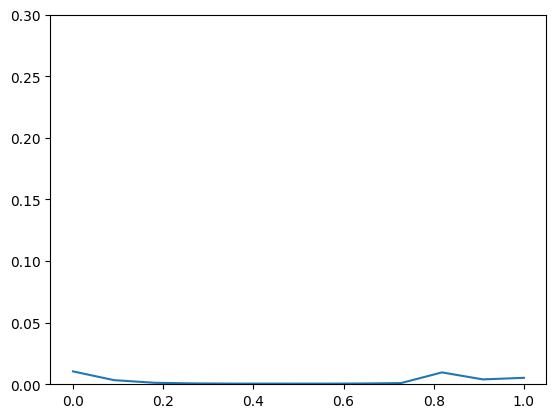

[25300] 0.00367
[25350] 0.00240
[25400] 0.00199
[25450] 0.00078
[25500] 0.00145


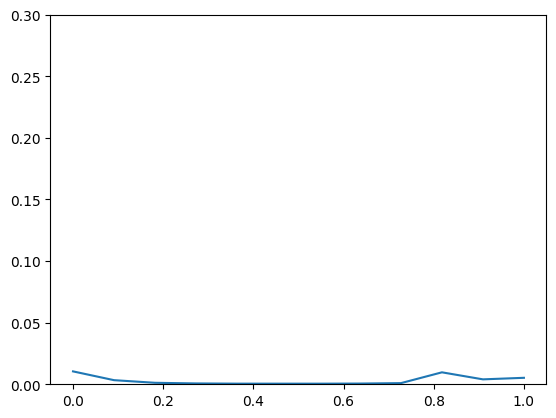

[25550] 0.00077
[25600] 0.00197
[25650] 0.01049
[25700] 0.00172
[25750] 0.00781


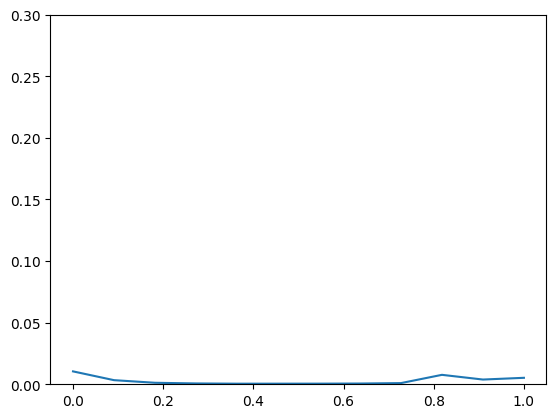

[25800] 0.00168
[25850] 0.00131
[25900] 0.00142
[25950] 0.00259
[26000] 0.00138


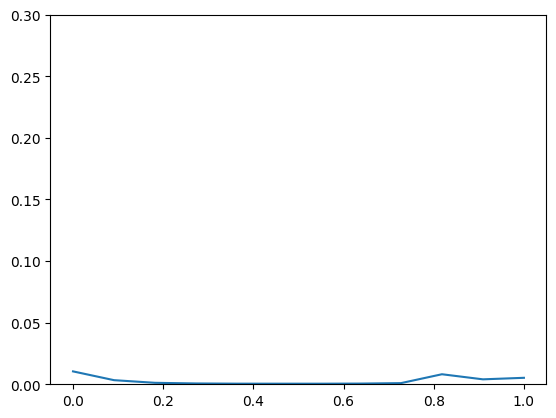

[26050] 0.01344
[26100] 0.00168
[26150] 0.00171
[26200] 0.00167
[26250] 0.00053


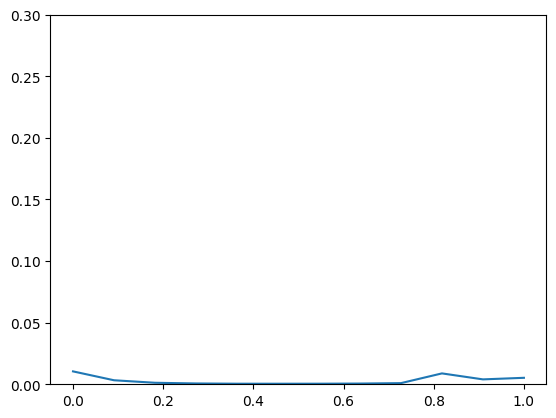

[26300] 0.00085
[26350] 0.00270
[26400] 0.00291
[26450] 0.00329
[26500] 0.00109


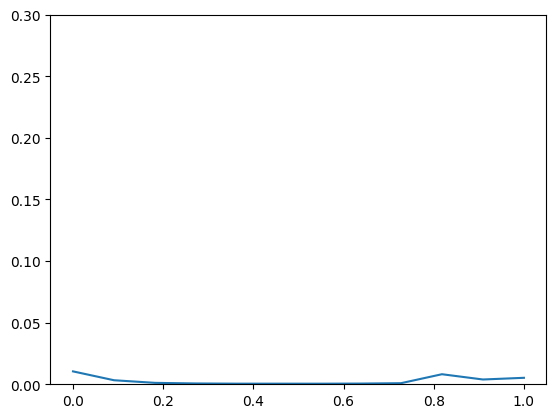

[26550] 0.00181
[26600] 0.00852
[26650] 0.00082
[26700] 0.00058
[26750] 0.00889


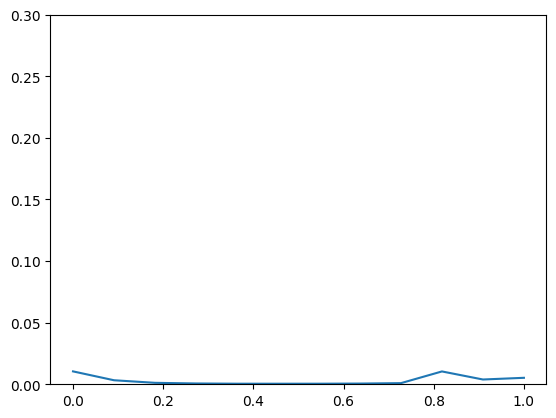

[26800] 0.00159
[26850] 0.01630
[26900] 0.00378
[26950] 0.00179
[27000] 0.00298


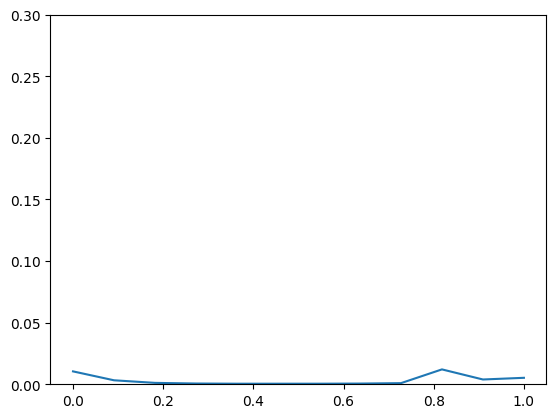

[27050] 0.00173
[27100] 0.00052
[27150] 0.00330
[27200] 0.00107
[27250] 0.00071


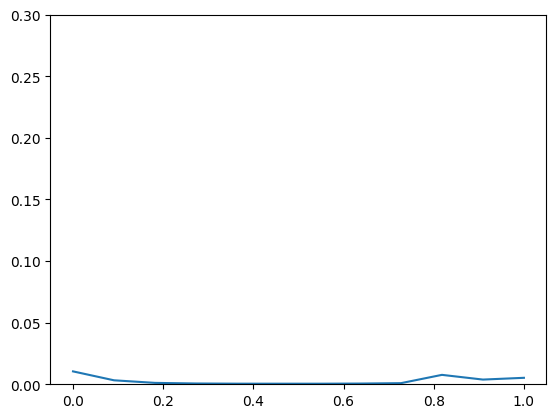

[27300] 0.00219
[27350] 0.00994
[27400] 0.00061
[27450] 0.00157
[27500] 0.00282


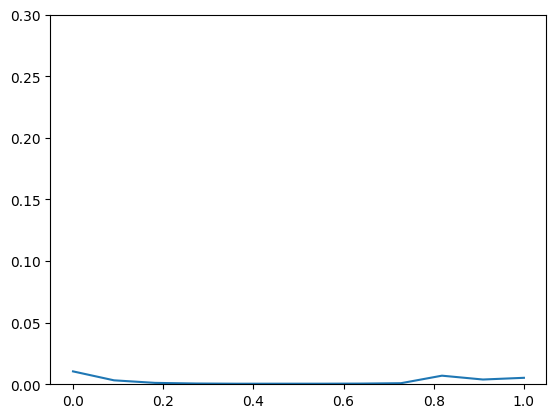

[27550] 0.00159
[27600] 0.00480
[27650] 0.00394
[27700] 0.00417
[27750] 0.00047


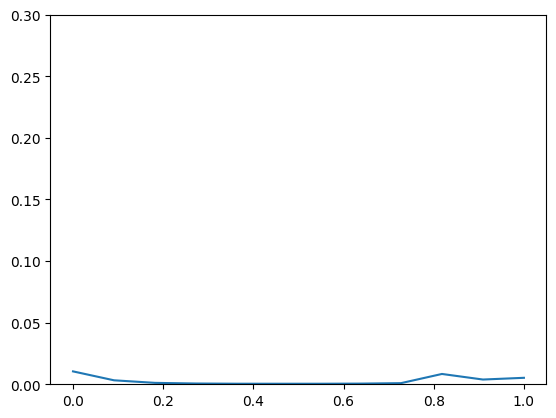

[27800] 0.00472
[27850] 0.00087
[27900] 0.00311
[27950] 0.00625
[28000] 0.00053


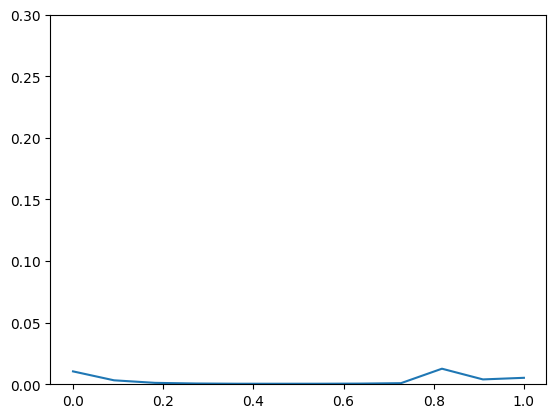

[28050] 0.00236
[28100] 0.00346
[28150] 0.00092
[28200] 0.00072
[28250] 0.00172


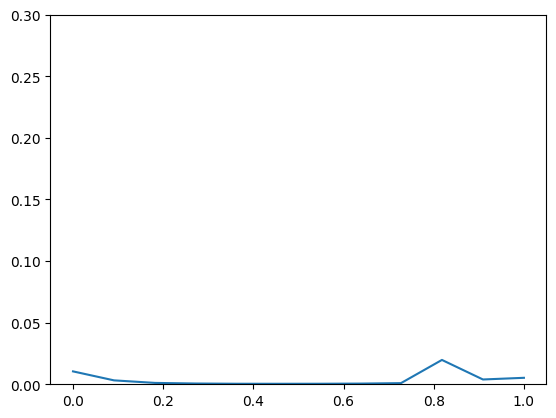

[28300] 0.00112
[28350] 0.00381
[28400] 0.00234
[28450] 0.00156
[28500] 0.00227


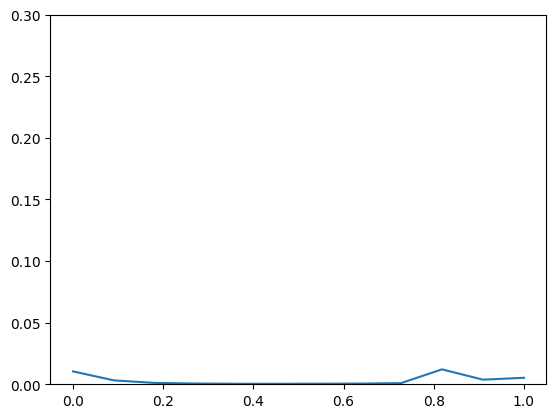

[28550] 0.00456
[28600] 0.00096
[28650] 0.00081
[28700] 0.01081
[28750] 0.00199


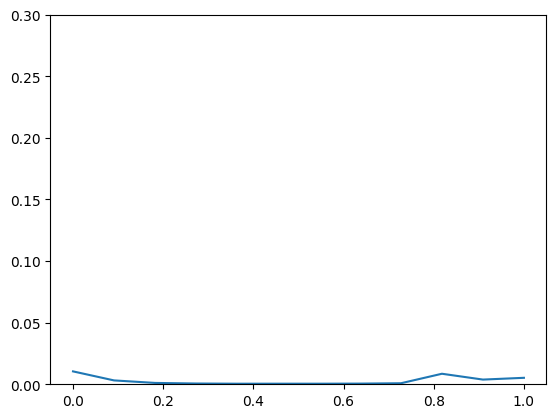

[28800] 0.00077
[28850] 0.00189
[28900] 0.00239
[28950] 0.00246
[29000] 0.00185


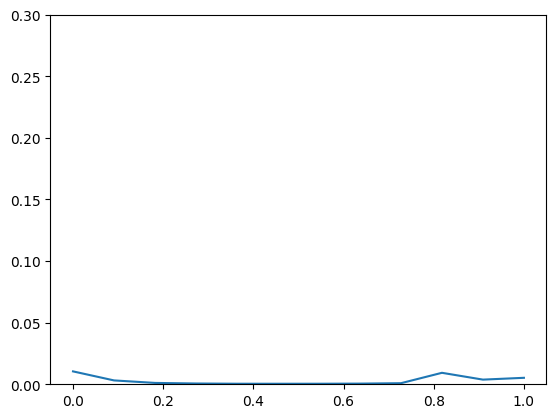

[29050] 0.00294
[29100] 0.00275
[29150] 0.00362
[29200] 0.00103
[29250] 0.00078


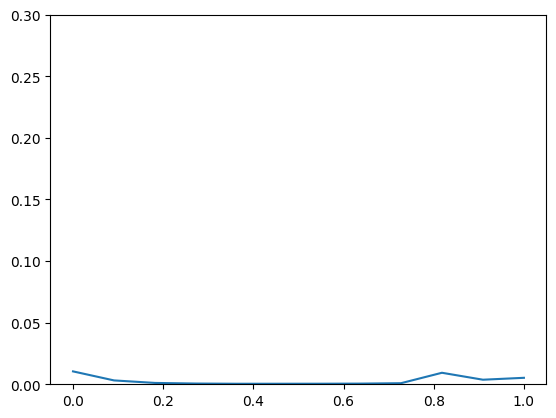

[29300] 0.00059
[29350] 0.00138
[29400] 0.00443
[29450] 0.00133
[29500] 0.00133


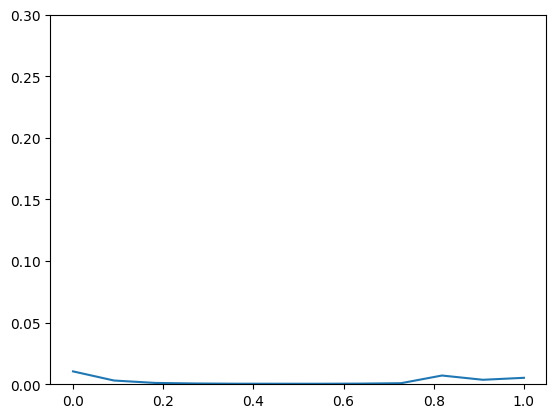

[29550] 0.00137
[29600] 0.00443
[29650] 0.00236
[29700] 0.00080
[29750] 0.00674


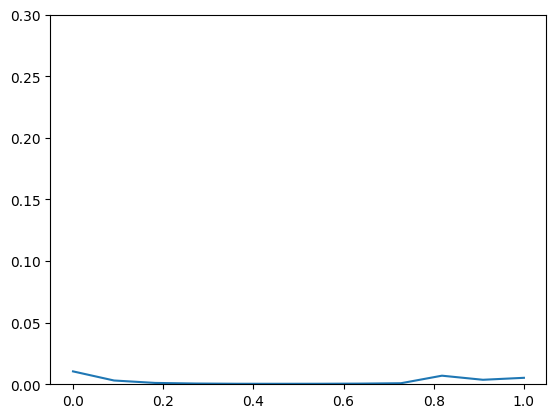

[29800] 0.00324
[29850] 0.00829
[29900] 0.00309
[29950] 0.00398
[30000] 0.00327


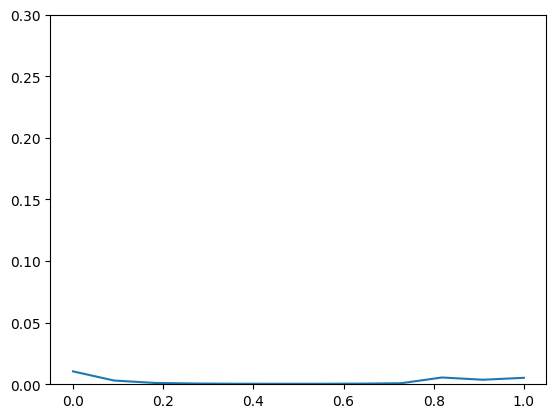

[30050] 0.00340
[30100] 0.00788
[30150] 0.00247
[30200] 0.00150
[30250] 0.00139


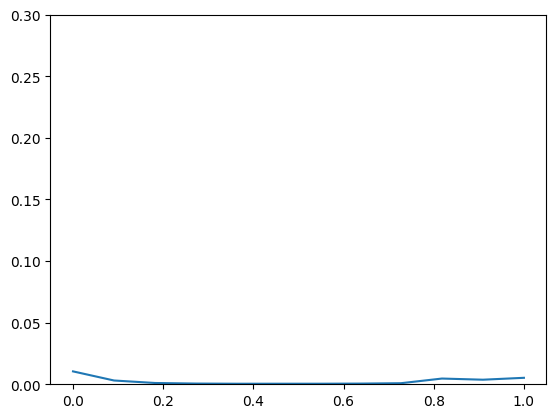

[30300] 0.00702
[30350] 0.00188
[30400] 0.00210
[30450] 0.00173
[30500] 0.00108


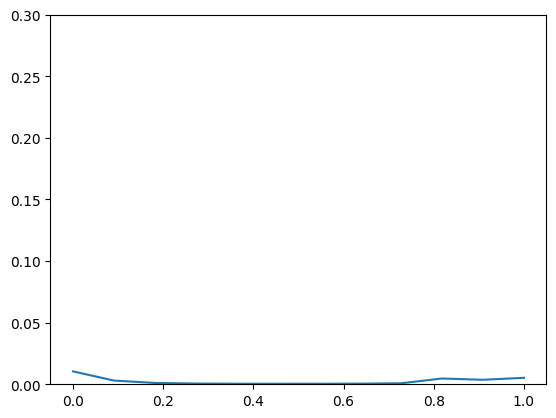

[30550] 0.00625
[30600] 0.00493
[30650] 0.00364
[30700] 0.00267
[30750] 0.00075


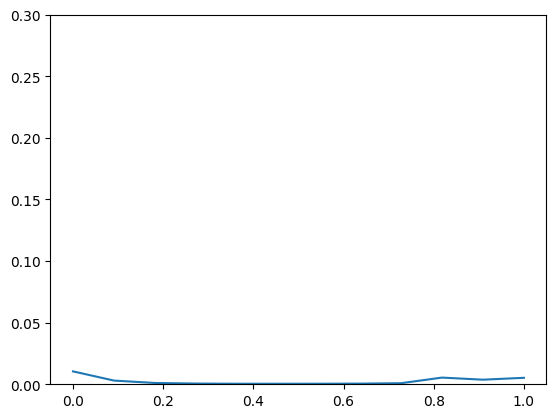

[30800] 0.00206
[30850] 0.00980
[30900] 0.00054
[30950] 0.00064
[31000] 0.00355


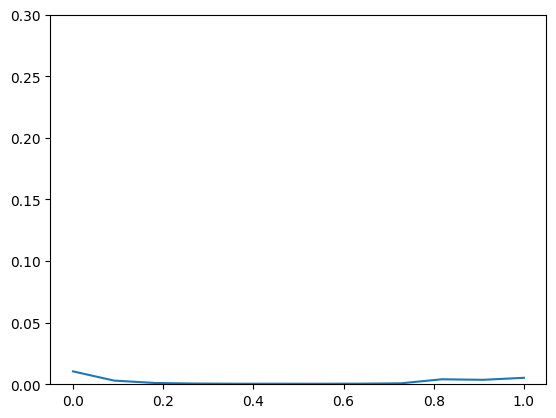

[31050] 0.00103
[31100] 0.00083
[31150] 0.00185
[31200] 0.00144
[31250] 0.00342


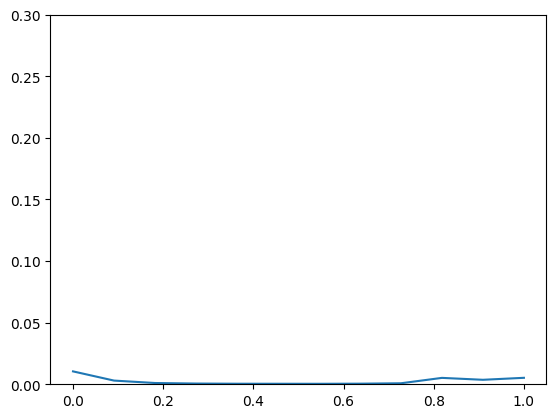

[31300] 0.00751
[31350] 0.00153
[31400] 0.00409
[31450] 0.00190
[31500] 0.00297


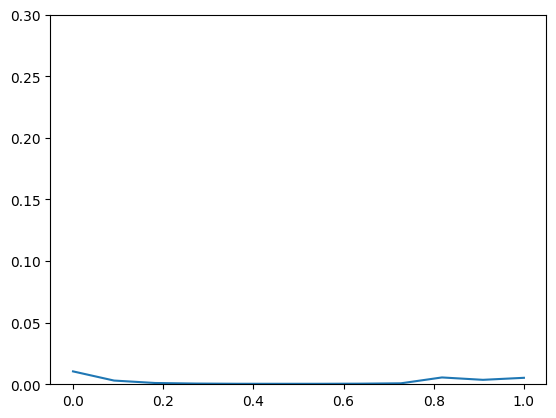

[31550] 0.00453
[31600] 0.00271
[31650] 0.00979
[31700] 0.00087
[31750] 0.00354


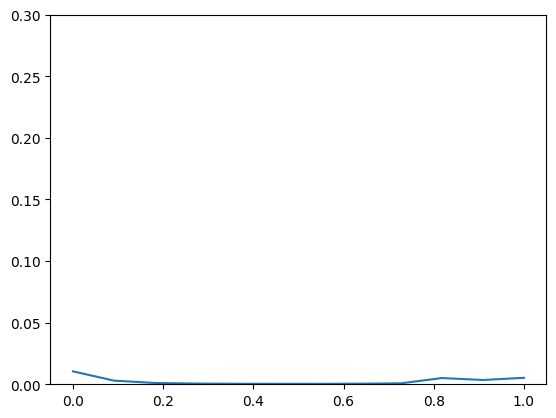

[31800] 0.00244
[31850] 0.00210
[31900] 0.00120
[31950] 0.00086
[32000] 0.00188


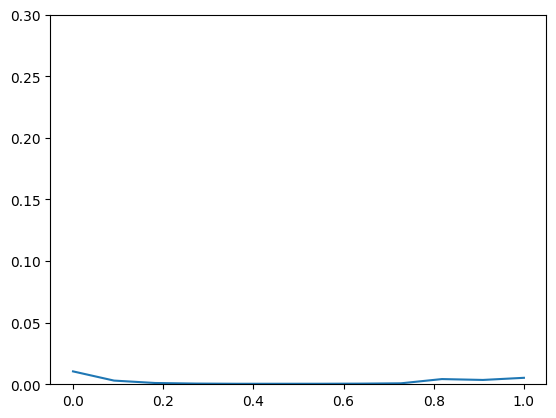

[32050] 0.00073
[32100] 0.00097
[32150] 0.00282
[32200] 0.00264
[32250] 0.00305


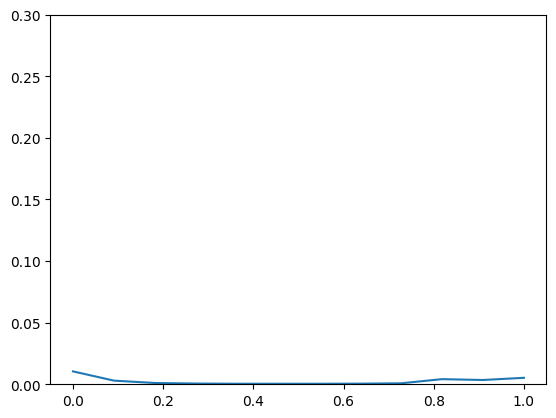

[32300] 0.00114
[32350] 0.00292
[32400] 0.00102
[32450] 0.00281
[32500] 0.00512


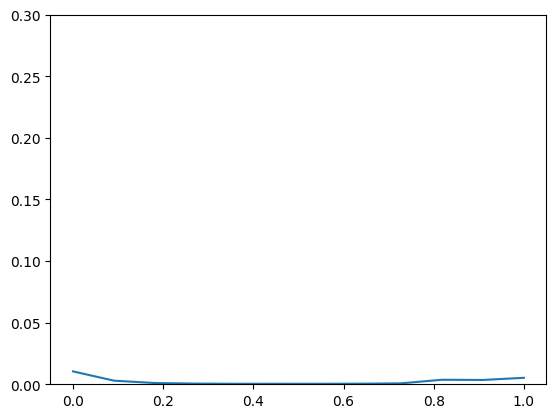

[32550] 0.00165
[32600] 0.00107
[32650] 0.00235
[32700] 0.00255
[32750] 0.00116


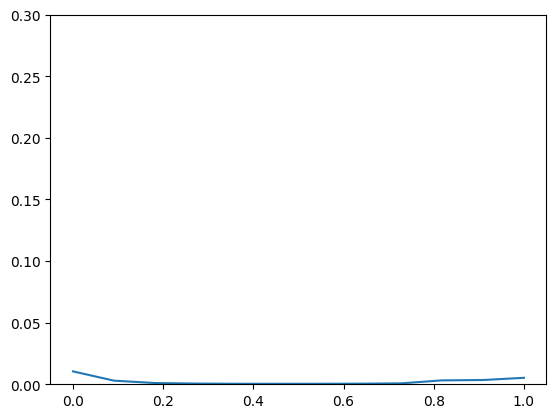

[32800] 0.00341
[32850] 0.00270
[32900] 0.00204
[32950] 0.00164
[33000] 0.00060


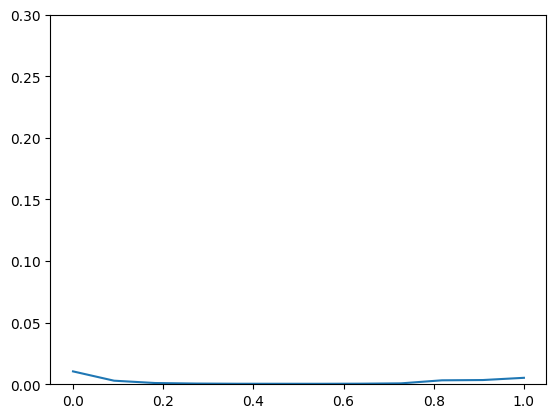

[33050] 0.00321
[33100] 0.00317
[33150] 0.00562
[33200] 0.00421
[33250] 0.00333


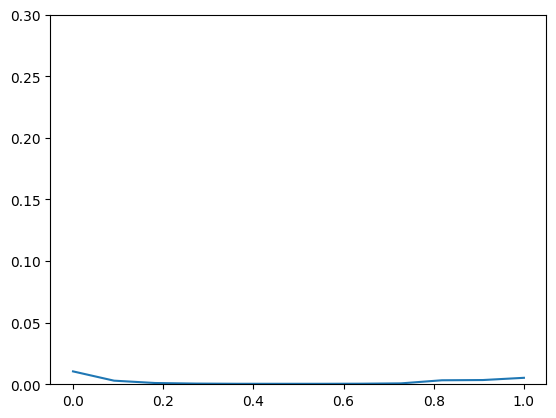

[33300] 0.00282
[33350] 0.00109
[33400] 0.00073
[33450] 0.00208
[33500] 0.00093


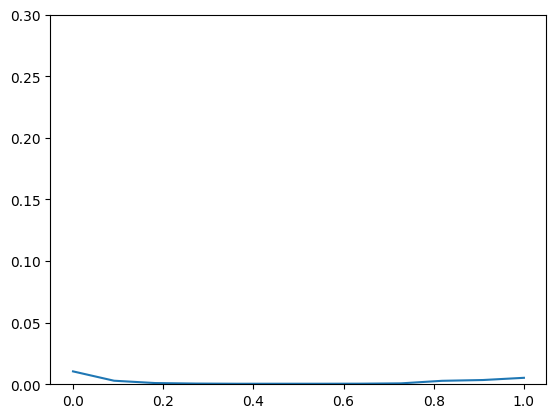

[33550] 0.00254
[33600] 0.00267
[33650] 0.00583
[33700] 0.00130
[33750] 0.00290


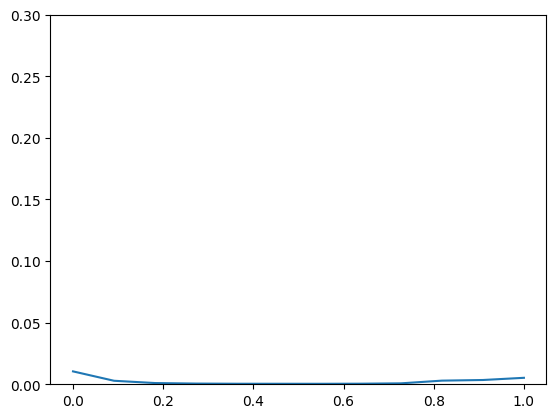

[33800] 0.00427
[33850] 0.00206
[33900] 0.00122
[33950] 0.00062
[34000] 0.00082


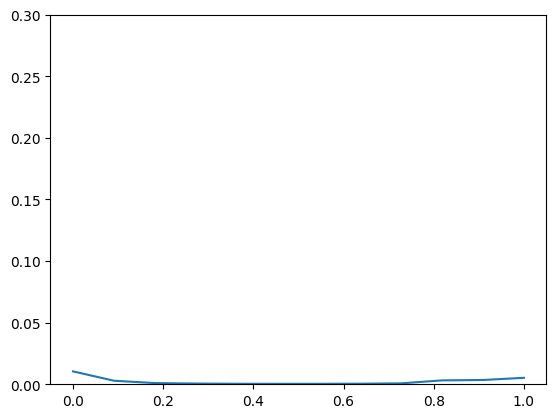

[34050] 0.00081
[34100] 0.00824
[34150] 0.00041
[34200] 0.00153
[34250] 0.00064


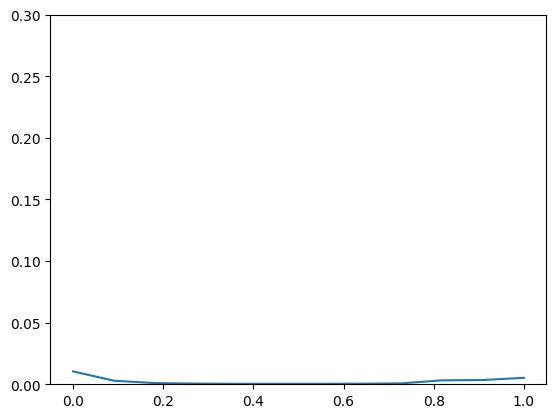

[34300] 0.00083
[34350] 0.00211
[34400] 0.00230
[34450] 0.00296
[34500] 0.00042


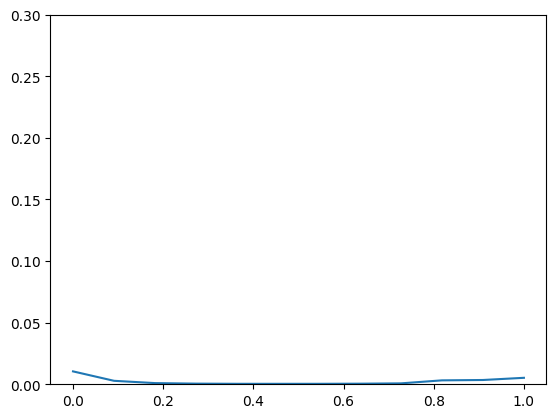

[34550] 0.00044
[34600] 0.00082
[34650] 0.00129
[34700] 0.00054
[34750] 0.00048


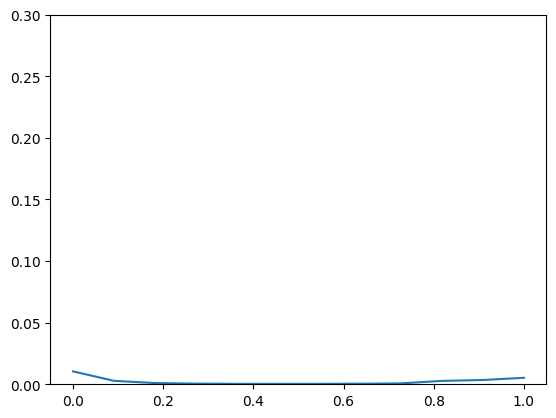

[34800] 0.00304
[34850] 0.00150
[34900] 0.00078
[34950] 0.00693
[35000] 0.00175


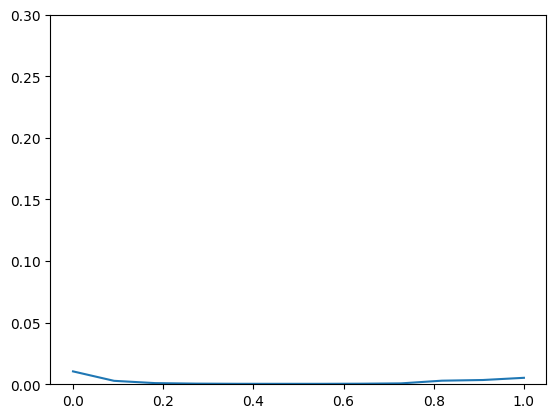

[35050] 0.00168
[35100] 0.00651
[35150] 0.00158
[35200] 0.00174
[35250] 0.00250


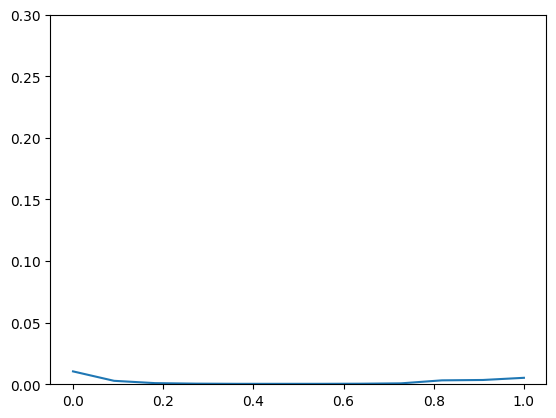

[35300] 0.00347
[35350] 0.00042
[35400] 0.00457
[35450] 0.00135
[35500] 0.00262


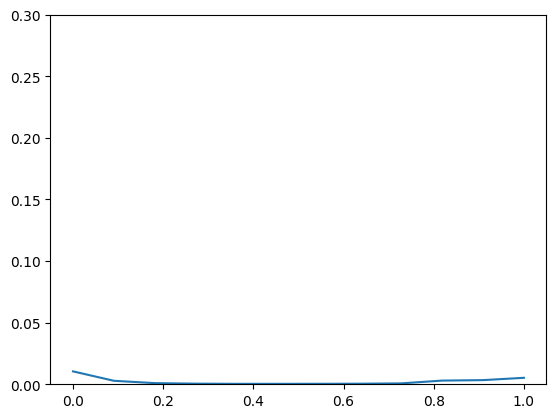

[35550] 0.00313
[35600] 0.00056
[35650] 0.00055
[35700] 0.00152
[35750] 0.00244


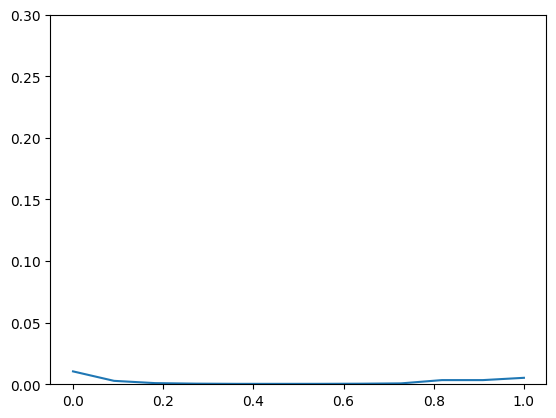

[35800] 0.00165
[35850] 0.00161
[35900] 0.00154
[35950] 0.00240
[36000] 0.00721


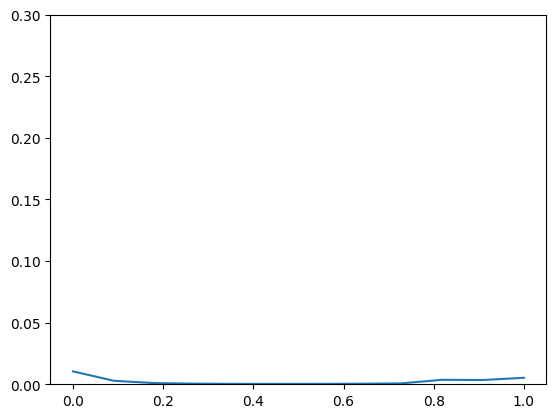

[36050] 0.00707
[36100] 0.00288
[36150] 0.00170
[36200] 0.00045
[36250] 0.00198


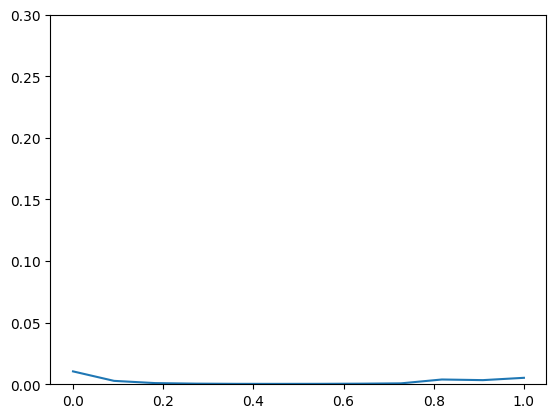

[36300] 0.00397
[36350] 0.00285
[36400] 0.00223
[36450] 0.00176
[36500] 0.00174


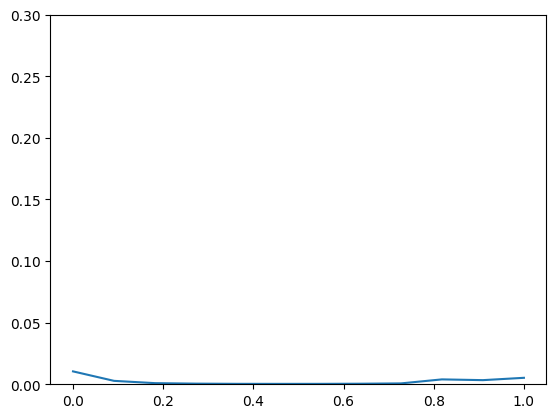

[36550] 0.00163
[36600] 0.00169
[36650] 0.00487
[36700] 0.00080
[36750] 0.00261


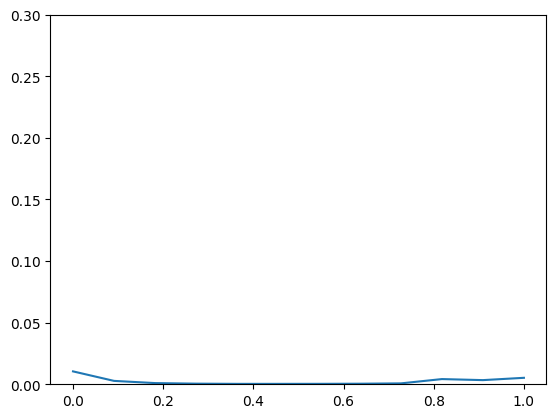

[36800] 0.00203
[36850] 0.00068
[36900] 0.00489
[36950] 0.00246
[37000] 0.00125


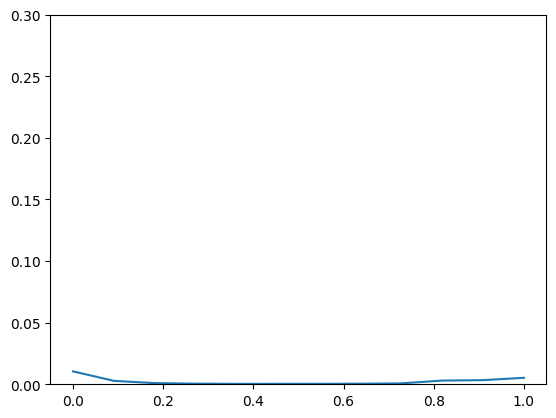

[37050] 0.00066
[37100] 0.00241
[37150] 0.00161
[37200] 0.00248
[37250] 0.00367


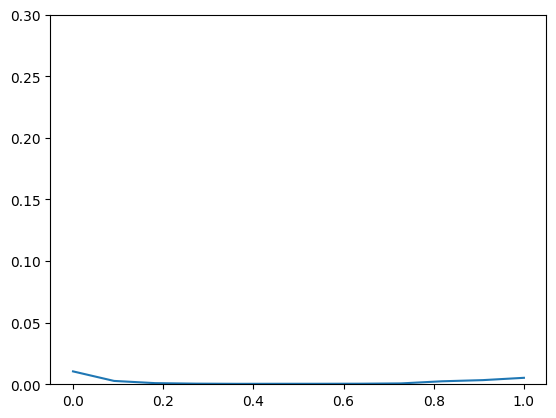

[37300] 0.00205
[37350] 0.00062
[37400] 0.00155
[37450] 0.00187
[37500] 0.00039


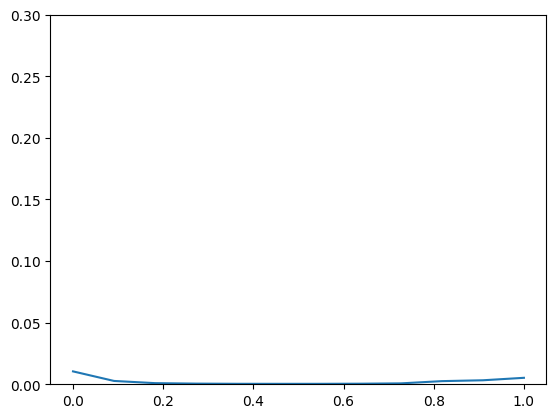

[37550] 0.00164
[37600] 0.00728
[37650] 0.00170
[37700] 0.00120
[37750] 0.00213


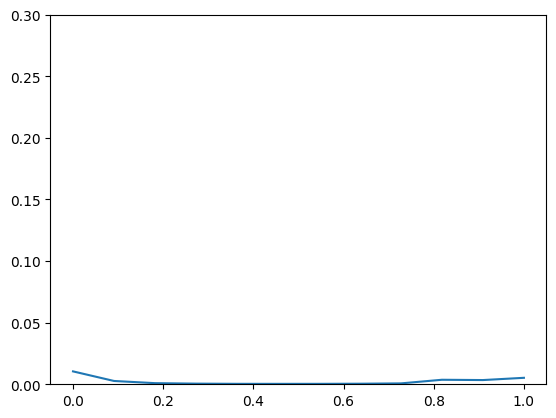

[37800] 0.00665
[37850] 0.00157
[37900] 0.00138
[37950] 0.00075
[38000] 0.00147


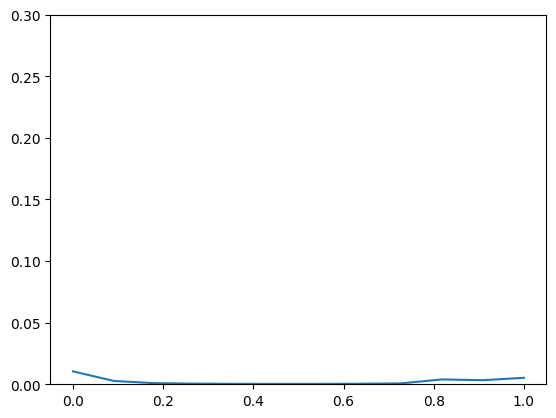

[38050] 0.00042
[38100] 0.00697
[38150] 0.00301
[38200] 0.00596
[38250] 0.00121


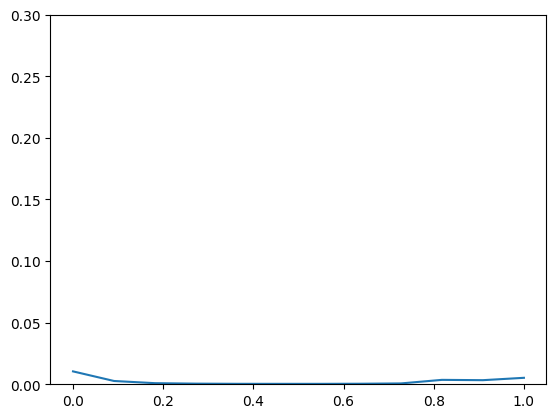

[38300] 0.00123
[38350] 0.00072
[38400] 0.00279
[38450] 0.00130
[38500] 0.00045


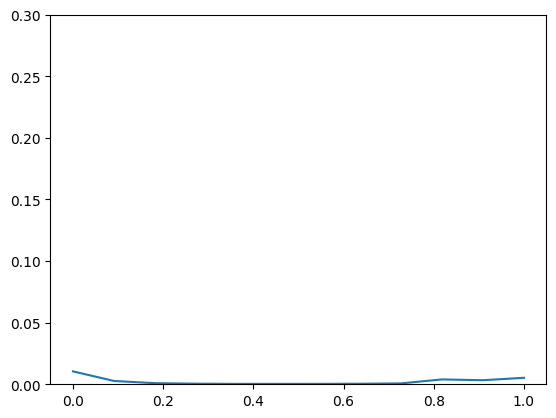

[38550] 0.00342
[38600] 0.00070
[38650] 0.00158
[38700] 0.00035
[38750] 0.00380


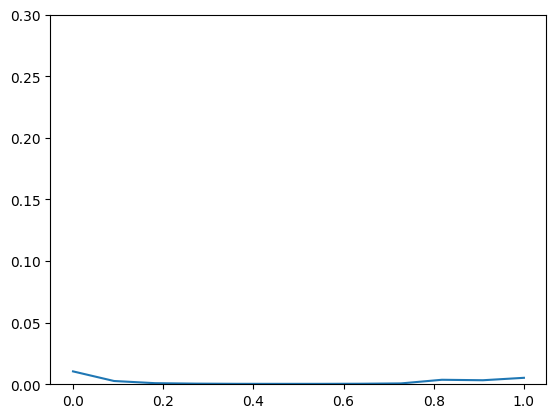

[38800] 0.00158
[38850] 0.00156
[38900] 0.00468
[38950] 0.00049
[39000] 0.00045


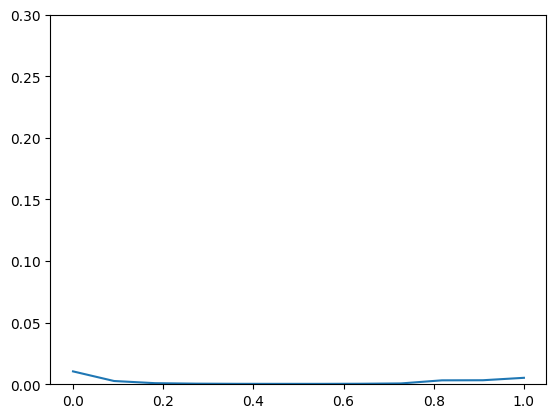

[39050] 0.00306
[39100] 0.00149
[39150] 0.00033
[39200] 0.00332
[39250] 0.00150


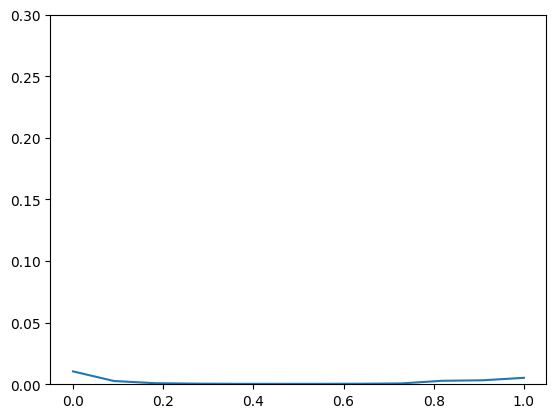

[39300] 0.00510
[39350] 0.00066
[39400] 0.00058
[39450] 0.00048
[39500] 0.00224


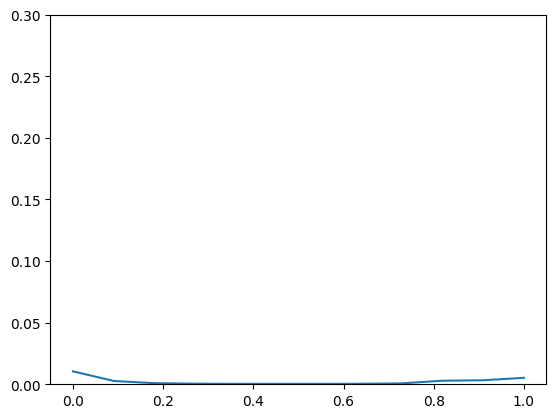

[39550] 0.00189
[39600] 0.00283
[39650] 0.00292
[39700] 0.00064
[39750] 0.00074


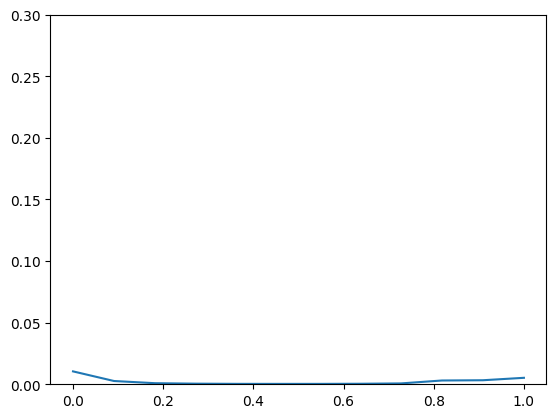

[39800] 0.00155
[39850] 0.00177
[39900] 0.00171
[39950] 0.00057
[40000] 0.01254


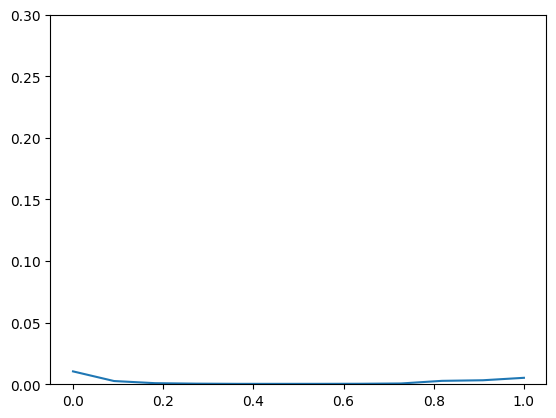

[40050] 0.00063
[40100] 0.00204
[40150] 0.00144
[40200] 0.00615
[40250] 0.00099


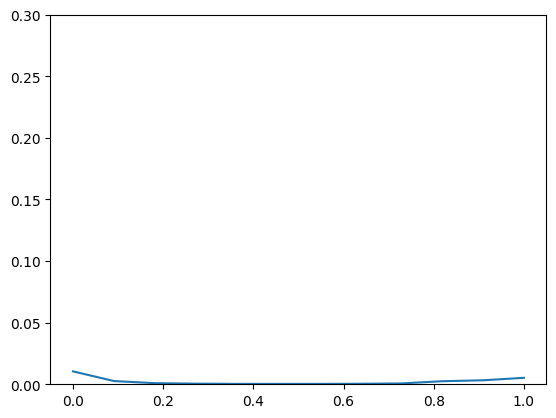

[40300] 0.00478
[40350] 0.00171
[40400] 0.00663
[40450] 0.00367
[40500] 0.00058


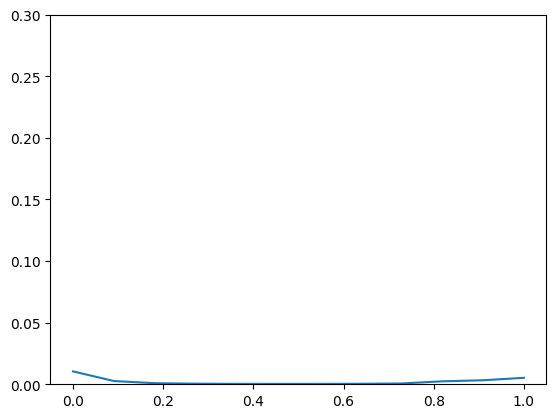

[40550] 0.00156
[40600] 0.00039
[40650] 0.00619
[40700] 0.00163
[40750] 0.00602


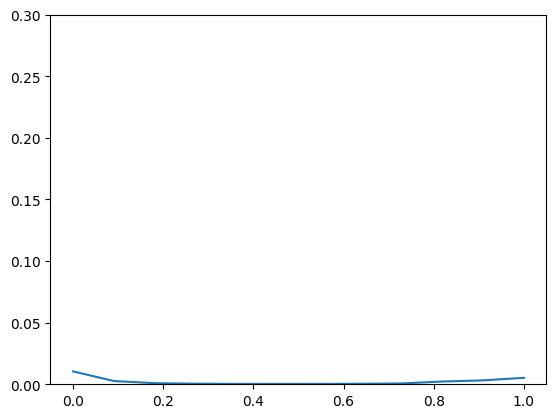

[40800] 0.00148
[40850] 0.00120
[40900] 0.00242
[40950] 0.00435
[41000] 0.00236


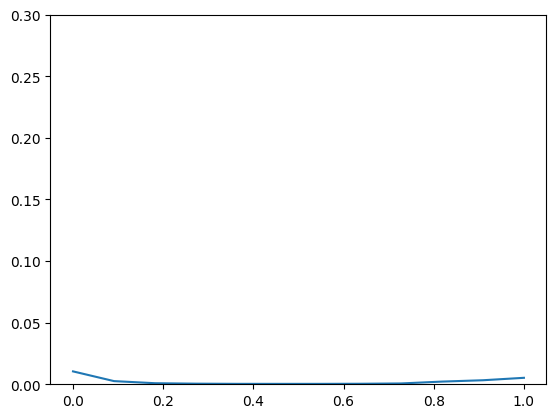

[41050] 0.00673
[41100] 0.00660
[41150] 0.00120
[41200] 0.00060
[41250] 0.00046


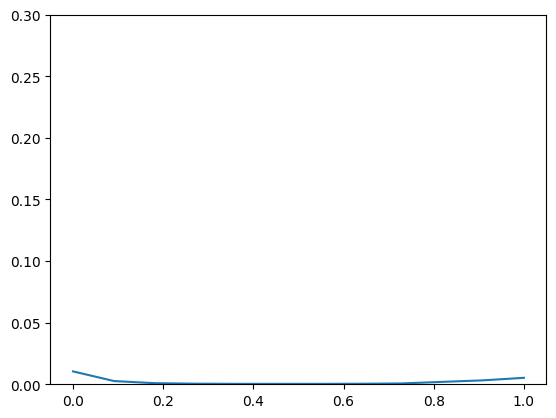

[41300] 0.01103
[41350] 0.00149
[41400] 0.00749
[41450] 0.00152
[41500] 0.00046


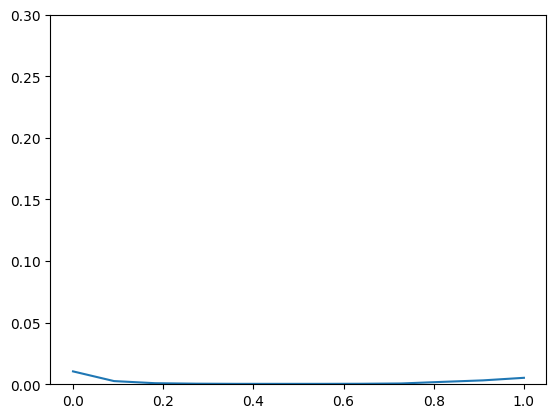

[41550] 0.00464
[41600] 0.00123
[41650] 0.00036
[41700] 0.00295
[41750] 0.00763


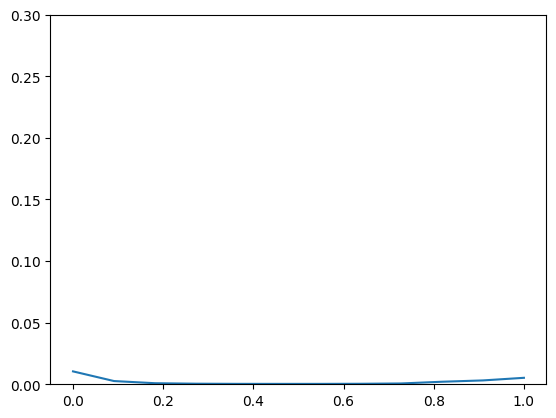

[41800] 0.00772
[41850] 0.00151
[41900] 0.00153
[41950] 0.00235
[42000] 0.00051


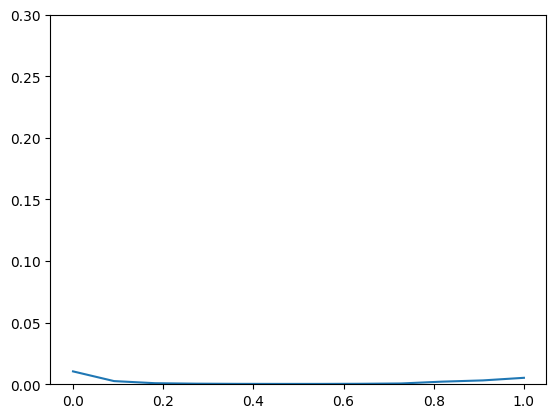

[42050] 0.00241
[42100] 0.00048
[42150] 0.00453
[42200] 0.00065
[42250] 0.00116


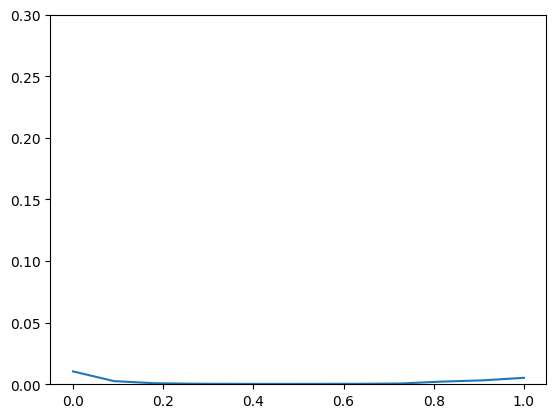

[42300] 0.00128
[42350] 0.00053
[42400] 0.00036
[42450] 0.00176
[42500] 0.00155


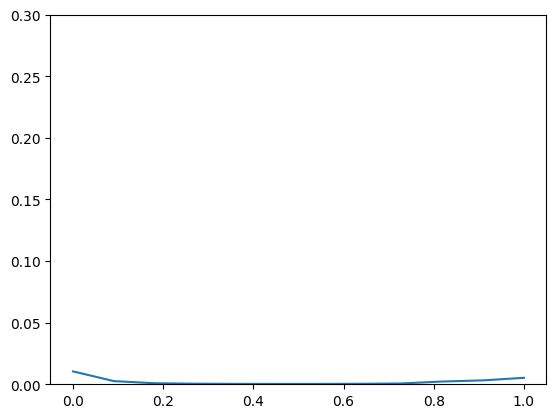

[42550] 0.00439
[42600] 0.00333
[42650] 0.00121
[42700] 0.00182
[42750] 0.00066


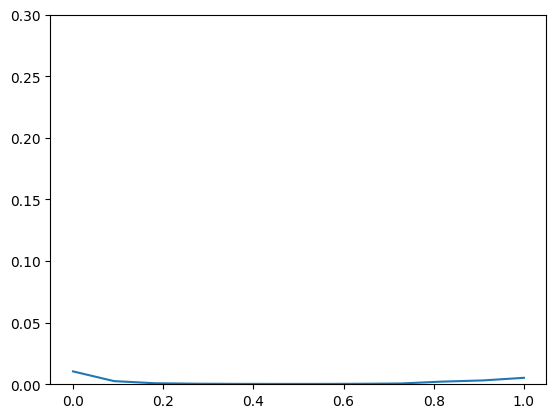

[42800] 0.00194
[42850] 0.00040
[42900] 0.00059
[42950] 0.00054
[43000] 0.00055


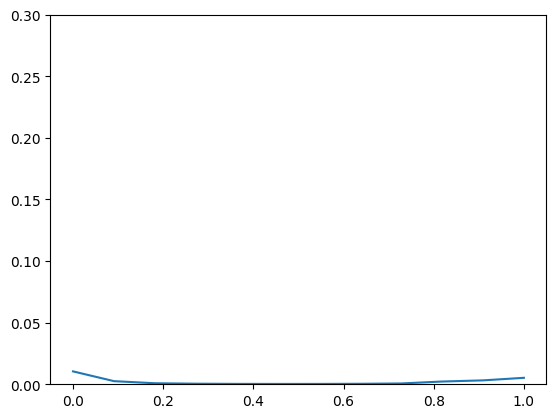

[43050] 0.00268
[43100] 0.00317
[43150] 0.00115
[43200] 0.00237
[43250] 0.00257


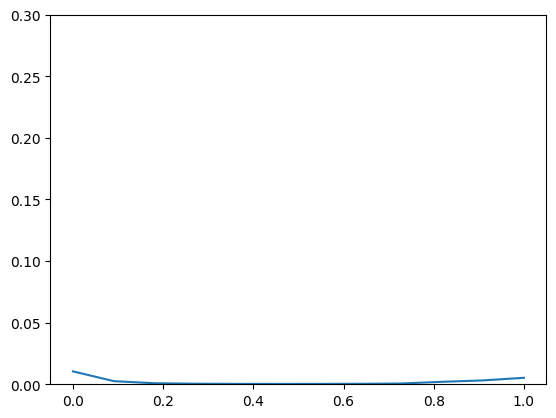

[43300] 0.00451
[43350] 0.00771
[43400] 0.00170
[43450] 0.00246
[43500] 0.00312


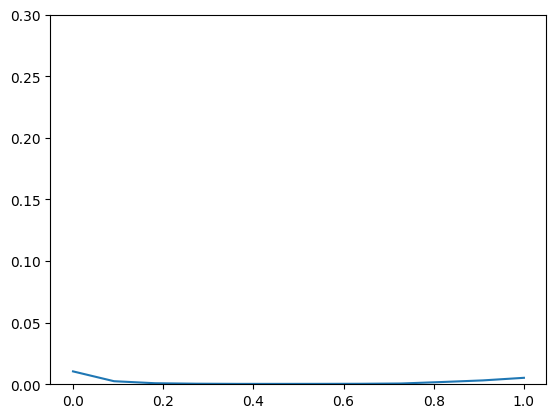

[43550] 0.00195
[43600] 0.00084
[43650] 0.00062
[43700] 0.00096
[43750] 0.00240


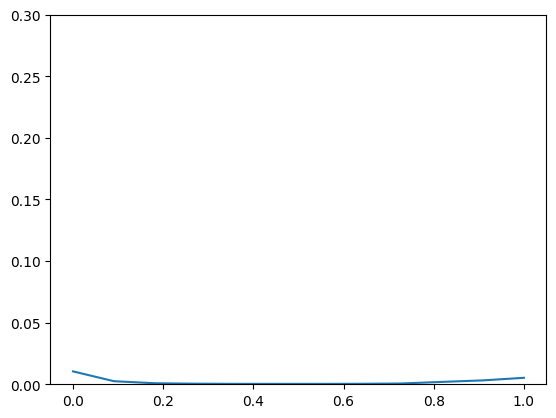

[43800] 0.00628
[43850] 0.00044
[43900] 0.00213
[43950] 0.00132
[44000] 0.00775


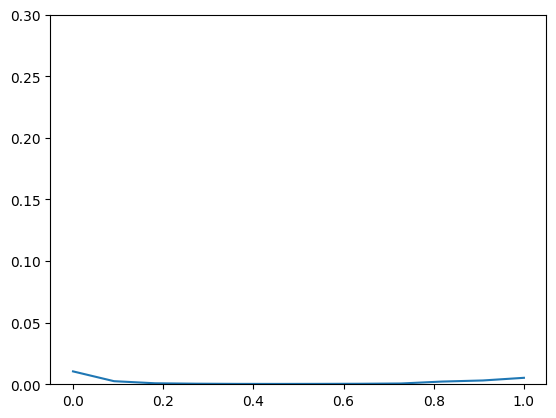

[44050] 0.00116
[44100] 0.00106
[44150] 0.00066
[44200] 0.00233
[44250] 0.00250


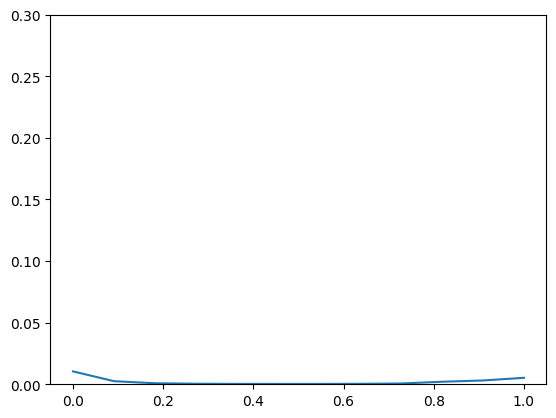

[44300] 0.00273
[44350] 0.00150
[44400] 0.00071
[44450] 0.00709
[44500] 0.00498


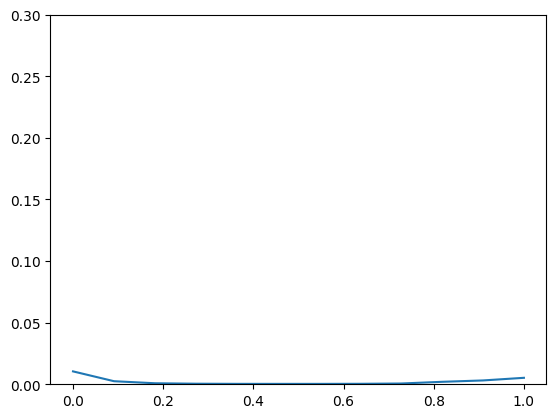

[44550] 0.00116
[44600] 0.00133
[44650] 0.00060
[44700] 0.00187
[44750] 0.00029


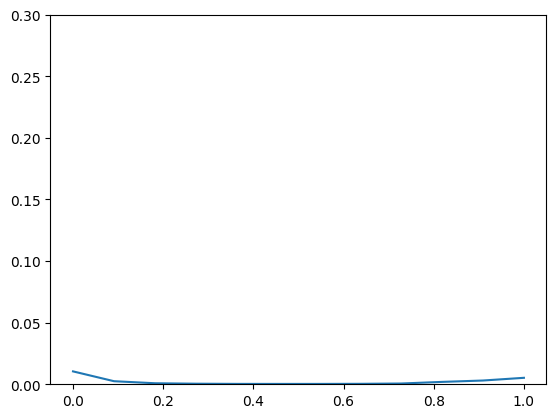

[44800] 0.00186
[44850] 0.00256
[44900] 0.00711
[44950] 0.00617
[45000] 0.00058


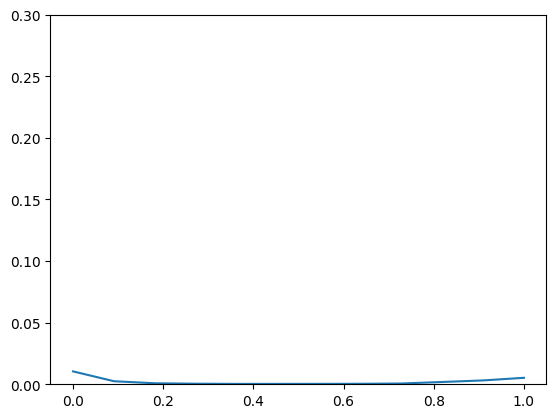

[45050] 0.00070
[45100] 0.00841
[45150] 0.00128
[45200] 0.00114
[45250] 0.01217


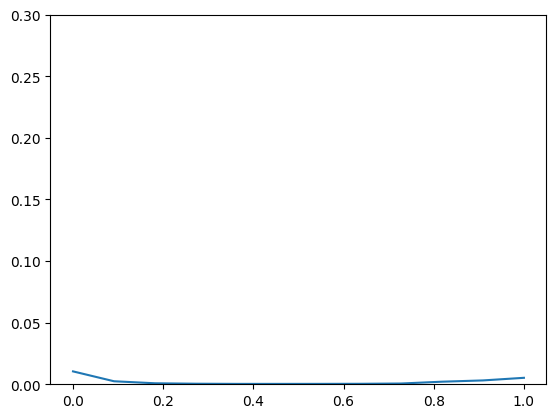

[45300] 0.00038
[45350] 0.00118
[45400] 0.00087
[45450] 0.00348
[45500] 0.00089


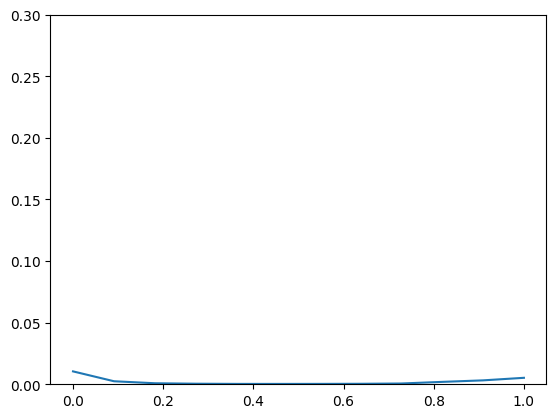

[45550] 0.00342
[45600] 0.00251
[45650] 0.00171
[45700] 0.00227
[45750] 0.00241


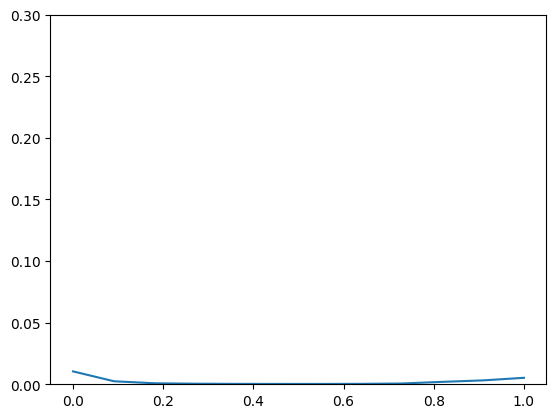

[45800] 0.00303
[45850] 0.00516
[45900] 0.00135
[45950] 0.00282
[46000] 0.00136


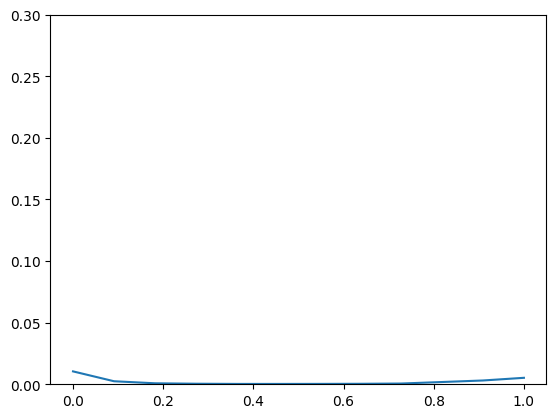

[46050] 0.00157
[46100] 0.00775
[46150] 0.00046
[46200] 0.00037
[46250] 0.00331


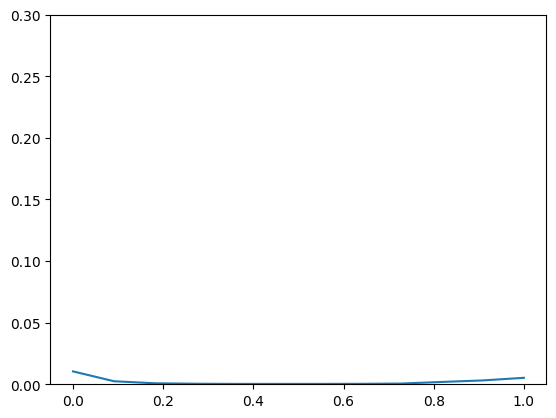

[46300] 0.00152
[46350] 0.00042
[46400] 0.00207
[46450] 0.00107
[46500] 0.00055


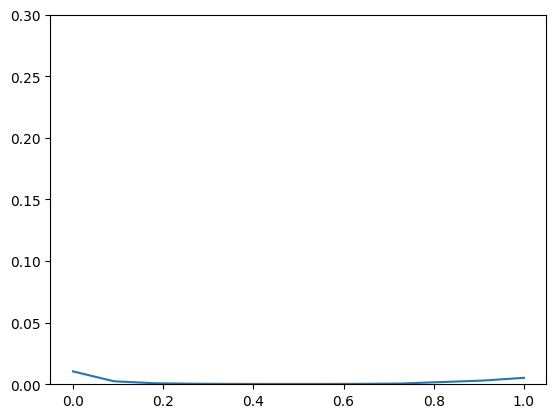

[46550] 0.00254
[46600] 0.00408
[46650] 0.00403
[46700] 0.00164
[46750] 0.00054


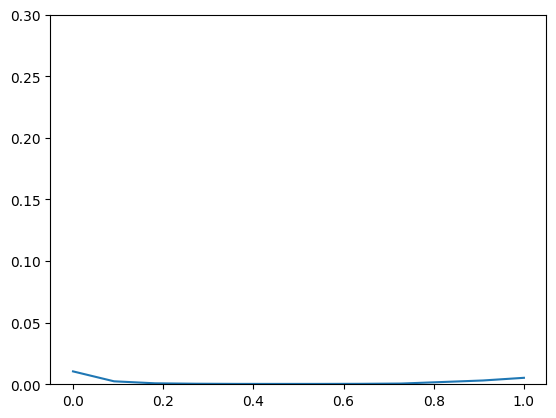

[46800] 0.00070
[46850] 0.00705
[46900] 0.00225
[46950] 0.00572
[47000] 0.00056


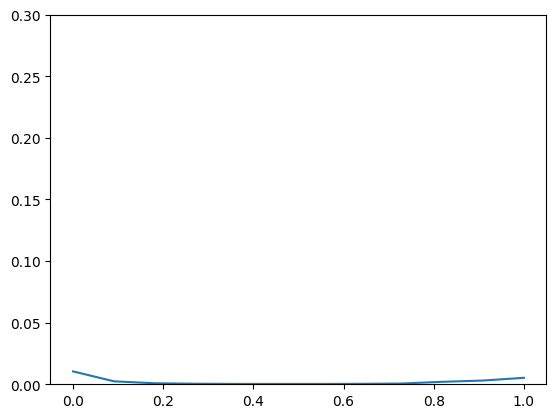

[47050] 0.00173
[47100] 0.00244
[47150] 0.00039
[47200] 0.00134
[47250] 0.00039


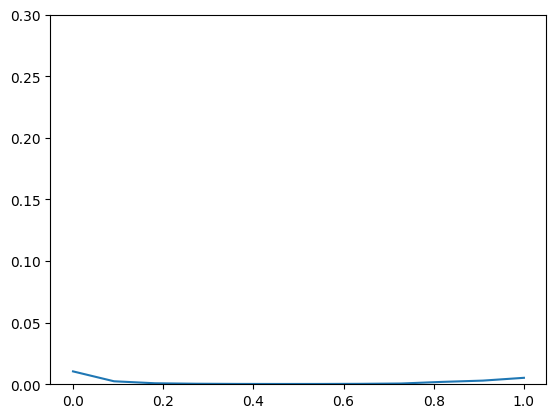

[47300] 0.00151
[47350] 0.00251
[47400] 0.00546
[47450] 0.00035
[47500] 0.00145


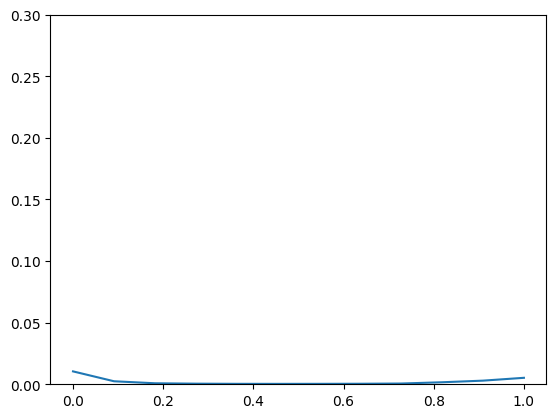

[47550] 0.00239
[47600] 0.00041
[47650] 0.00071
[47700] 0.00032
[47750] 0.00148


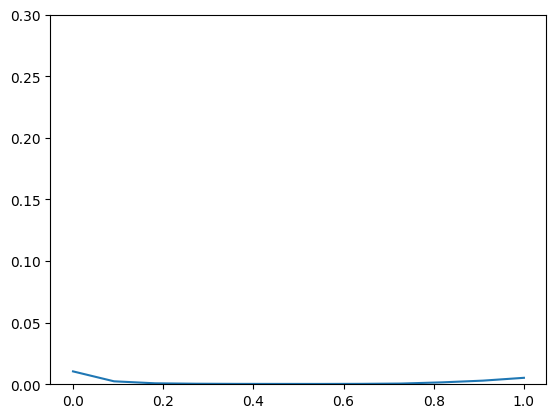

[47800] 0.00163
[47850] 0.00116
[47900] 0.00055
[47950] 0.00838
[48000] 0.00318


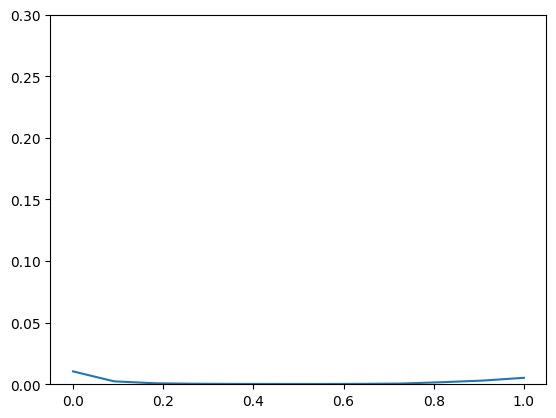

[48050] 0.00212
[48100] 0.00109
[48150] 0.00039
[48200] 0.00106
[48250] 0.00029


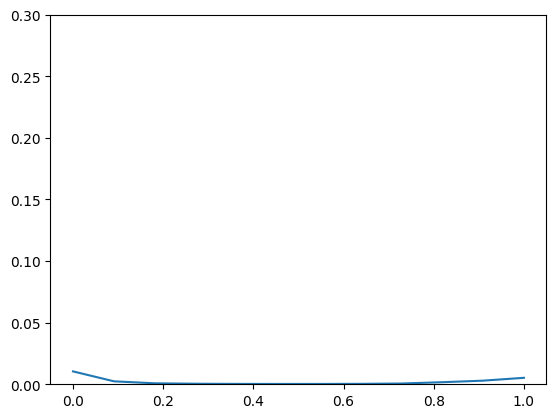

[48300] 0.00298
[48350] 0.00083
[48400] 0.00132
[48450] 0.00066
[48500] 0.00066


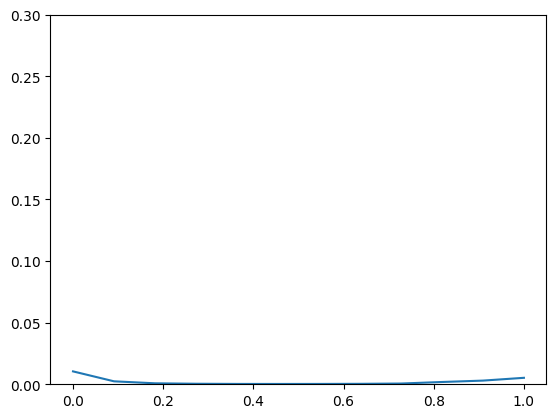

[48550] 0.00357
[48600] 0.00283
[48650] 0.00057
[48700] 0.00275
[48750] 0.00039


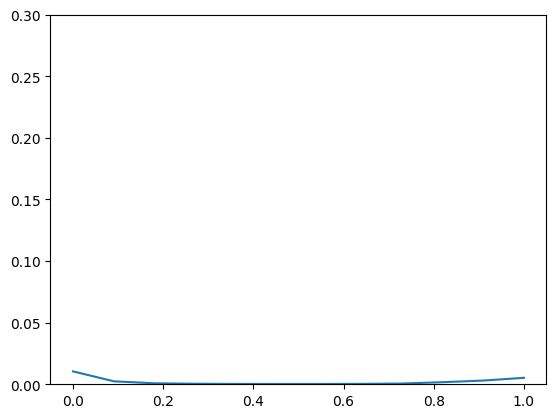

[48800] 0.00105
[48850] 0.00271
[48900] 0.00240
[48950] 0.00276
[49000] 0.00129


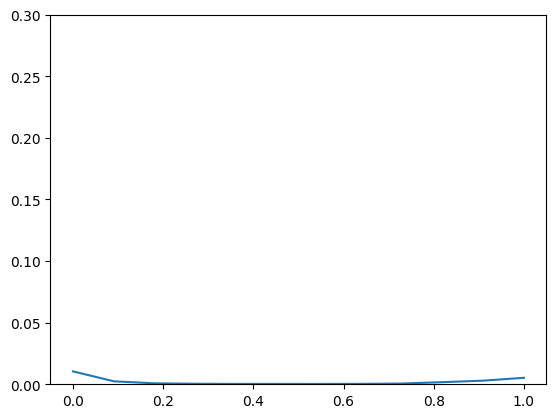

[49050] 0.00143
[49100] 0.00119
[49150] 0.00032
[49200] 0.00112
[49250] 0.00565


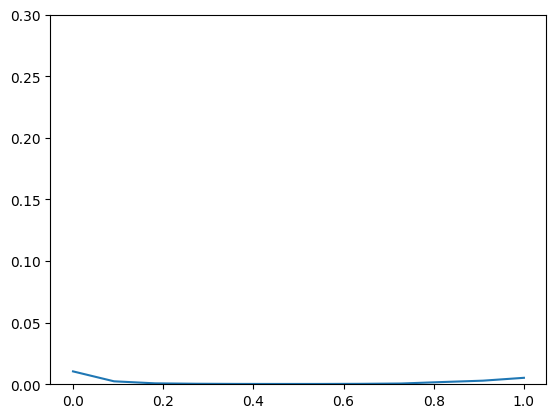

[49300] 0.00247
[49350] 0.00505
[49400] 0.00155
[49450] 0.00241
[49500] 0.00278


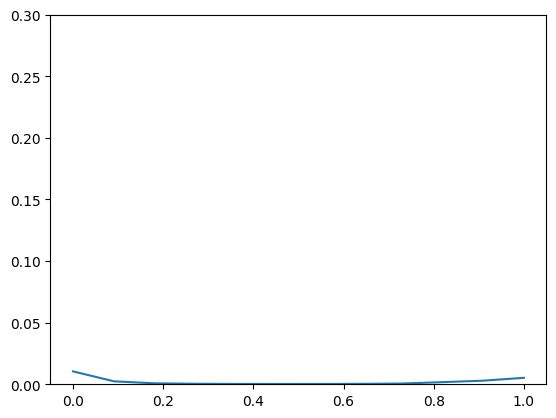

[49550] 0.00271
[49600] 0.00417
[49650] 0.00149
[49700] 0.00038
[49750] 0.00315


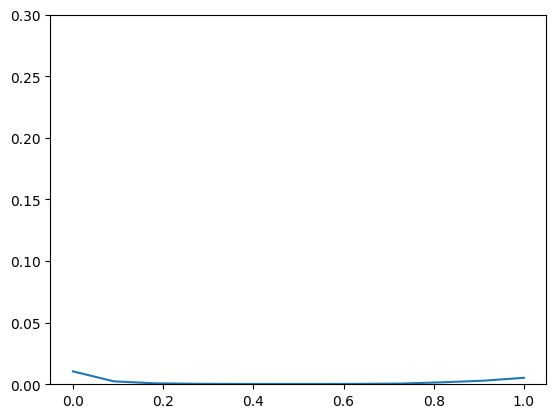

[49800] 0.00261
[49850] 0.00603
[49900] 0.00153
[49950] 0.00089


In [33]:
vis_loss_dynamics = []
for i in range(50_000):
    ts = torch.rand(cbs, 1, device=device)
    ws = connectome.phi(ts)
    loss = 0
    for w in ws:
        loss = loss + loss_for_w(w)
    
    loss = loss / cbs
    
    if i % 50 == 0:
        print(f'[{i:03}] {loss:.5f}')
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 250 == 0:
        with torch.inference_mode():
            ts = torch.linspace(0,1, (12), device=device)[:, None]
            losses = ts2loss(ts)
            
            vis_loss_dynamics.append( (i, losses) )
            plt.plot(ts.flatten().cpu(), [l.cpu().item() for l in losses])
            plt.ylim(0, 0.3)
            plt.show()

In [37]:
vis_loss_dynamics_np = [(i,np.array([t.item() for t in a])) for i,a in vis_loss_dynamics]

In [39]:
vis_loss_dynamics_np[0]

(0,
 array([0.01046778, 0.02073995, 0.05407862, 0.11520764, 0.19592839,
        0.2682206 , 0.30867764, 0.32222232, 0.32499209, 0.31222022,
        0.16631524, 0.00524835]))

In [44]:
ts = torch.linspace(0,1, (12))[:, None].numpy()

In [50]:
i, array = vis_loss_dynamics_np[0]
array

array([0.01046778, 0.02073995, 0.05407862, 0.11520764, 0.19592839,
       0.2682206 , 0.30867764, 0.32222232, 0.32499209, 0.31222022,
       0.16631524, 0.00524835])

(0.0, 0.35)

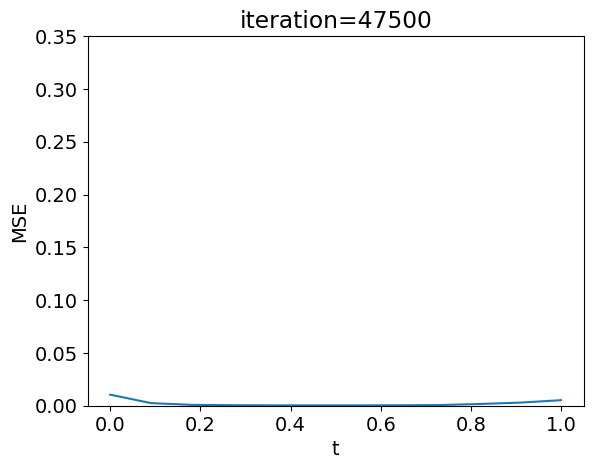

In [62]:
plt.rcParams['font.size'] = 14

plt.plot(ts, array)
plt.title(f'iteration={i:03}')
plt.xlabel('t')
plt.ylabel('MSE')
plt.ylim(0, 0.35)

In [57]:
array

(0,
 array([0.01046778, 0.02073995, 0.05407862, 0.11520764, 0.19592839,
        0.2682206 , 0.30867764, 0.32222232, 0.32499209, 0.31222022,
        0.16631524, 0.00524835]))

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Create a function to plot and save each frame
def save_plot(array, i, frame_number):
    plt.plot(ts, array)
    plt.title(f'iteration={i:03}')
    plt.xlabel('t')
    plt.ylabel('MSE')
    plt.ylim(0, 0.35)

    # plt.title(f'Frame {frame_number}')
    plt.savefig(f'frame_{frame_number}.png')

# Create and save the plots
for frame_number, (i, array) in enumerate(vis_loss_dynamics_np):
    save_plot(array, i, frame_number)
    plt.clf()

# Collect the saved plots and create a GIF
frames = []
for i in range(len(vis_loss_dynamics_np)):
    frames.append(Image.open(f'frame_{i}.png'))

# Save the GIF (adjust the duration as desired)
frames[0].save('animation.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)

# Clean up the individual frames (optional)
import os
for i in range(len(data)):
    os.remove(f'frame_{i}.png')


<Figure size 640x480 with 0 Axes>

In [67]:
frames[0].save('animation2.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)

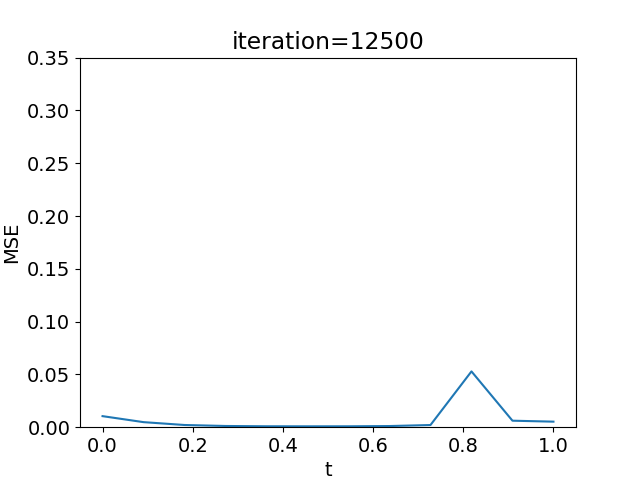

In [66]:
frames[50]